# Reducing Hotel Booking Cancellations: Pre-Treatment Exploration, Causal Design, and Post-Treatment Analysis

## Project Description
This project analyzes hotel booking cancellations using both predictive and causal methods.  
We test whether offering a **10% discount** to a specific customer segment—**Group bookings made ≥90 days in advance**—reduces cancellations and increases revenue.

### Approach
1. **Pre-Treatment Analysis:**  
   Explore the data, identify drivers of cancellations, and run a baseline predictive check to ensure signal quality and causal hygiene before any intervention.
2. **Post-Treatment Analysis:**  
   Evaluate the randomized 10% discount using ITT, CACE/LATE, and Value-ITT.  
   Extend with uplift modeling, SHAP explainability, ROI estimation, and policy learning.

**Purpose:** Provide an interpretable, end-to-end framework linking prediction, experimentation, and business decision-making.

### Notebooks Referenced
- **01_Pre_Treatment_Exploration_Causal_Design_1** *(this section)*
- **02_Causal_inference_experimental_design_2** *(subsequent section)*

### Business Question
**What can the business do to decrease cancellations?**

### Scope of This Section
**Pre-treatment EDA** and a **baseline predictive check** *(no causal claims)* to select **actionable levers** for testing in Notebook 02.


In [1]:
!pip install pytimetk --quiet
!pip install causalml lightgbm xgboost --quiet

# lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve, auc
import missingno as msno
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires dill<0.3.9,>=0.3.0, but you have dill 0.4.0 which is incompatible.
datasets 4.0.0 requires multiprocess<0.70.17, but you have multiprocess 0.70.18 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from pathlib import Path
from IPython.display import Image, display
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# path to data
BASE_DIR  = Path("/content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/")
DATA_DIR  = BASE_DIR / "data"
PLOTS_DIR = BASE_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

def show_img(path, width=900):
    p = Path(path)
    if not p.exists():
        print(f"Missing: {p}")
        return
    display(Image(filename=str(p), width=width))


Mounted at /content/drive


# **Data & Data Preparation**

## **Raw Data Preview**


In [3]:
df = pd.read_csv(os.path.join(DATA_DIR, "hotel_booking.csv"))
df_experiment = pd.read_csv(os.path.join(DATA_DIR, "hotel_cancellations_experiment2.csv"))
df.head(1)

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  customer_type  \
0                        0                     0       2  ...      Transient   

   adr required_car_parking_spaces total_of_special_requests  \
0  0.0                           0                         0   

  reservation_status reservation_status_date           name  \
0          Check-Out              2015-07-01  Ernest Barnes   

                         email  phone-number       credit_card  
0  Ernest.Barnes31@outlook.com  669-792-1661  ************4322  

[1 rows x 36 columns]

In [4]:
df.describe()

is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.156554   
std         0.482918     106.863097           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119390.000000              119390.000000   
mean                  27.165173                  15.798241   
std                   13.605138                   8.780829   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%                   38.000000                  23.000000   
max                   53.000000                  31.000000   

       stays_in_weekend_nights  stays_in_week_nights         adults  \
count            119390.000000         119390.000000  119390.000000   
mean                  0.927599              2.500302       1.856403   
std                   0.998613              1.908286       0.579261   
min                   0.000000              0.000000       0.000000   
25%                   0.000000              1.000000       2.000000   
50%                   1.000000              2.000000       2.000000   
75%                   2.000000              3.000000       2.000000   
max                  19.000000             50.000000      55.000000   

            children         babies  is_repeated_guest  \
count  119386.000000  119390.000000      119390.000000   
mean        0.103890       0.007949           0.031912   
std         0.398561       0.097436           0.175767   
min         0.000000       0.000000           0.000000   
25%         0.000000       0.000000           0.000000   
50%         0.000000       0.000000           0.000000   
75%         0.000000       0.000000           0.000000   
max        10.000000      10.000000           1.000000   

       previous_cancellations  previous_bookings_not_canceled  \
count           119390.000000                   119390.000000   
mean                 0.087118                        0.137097   
std                  0.844336                        1.497437   
min                  0.000000                        0.000000   
25%                  0.000000                        0.000000   
50%                  0.000000                        0.000000   
75%                  0.000000                        0.000000   
max                 26.000000                       72.000000   

       booking_changes          agent      company  days_in_waiting_list  \
count    119390.000000  103050.000000  6797.000000         119390.000000   
mean          0.221124      86.693382   189.266735              2.321149   
std           0.652306     110.774548   131.655015             17.594721   
min           0.000000       1.000000     6.000000              0.000000   
25%           0.000000       9.000000    62.000000              0.000000   
50%           0.000000      14.000000   179.000000              0.000000   
75%           0.000000     229.000000   270.000000              0.000000   
max          21.000000     535.000000   543.000000            391.000000   

                 adr  required_car_parking_spaces  total_of_special_requests  
count  119390.000000                119390.000000              119390.000000  
mean      101.831122                     0.062518                   0.571363  
std        50.535790                     0.245291                   0.792798  
min        -6.380000                     0.000000                   0.000000  
25%        69.290000                     0.000000                   0.000000  
50%        94.57500

### Structure
Each record represents a single hotel booking, containing fields for:
- **Booking attributes:** lead time, arrival date, ADR (average daily rate), deposit type, number of nights
- **Customer info:** adults, children, babies, market segment, distribution channel
- **Outcome:** `is_canceled` (1 = canceled, 0 = completed)

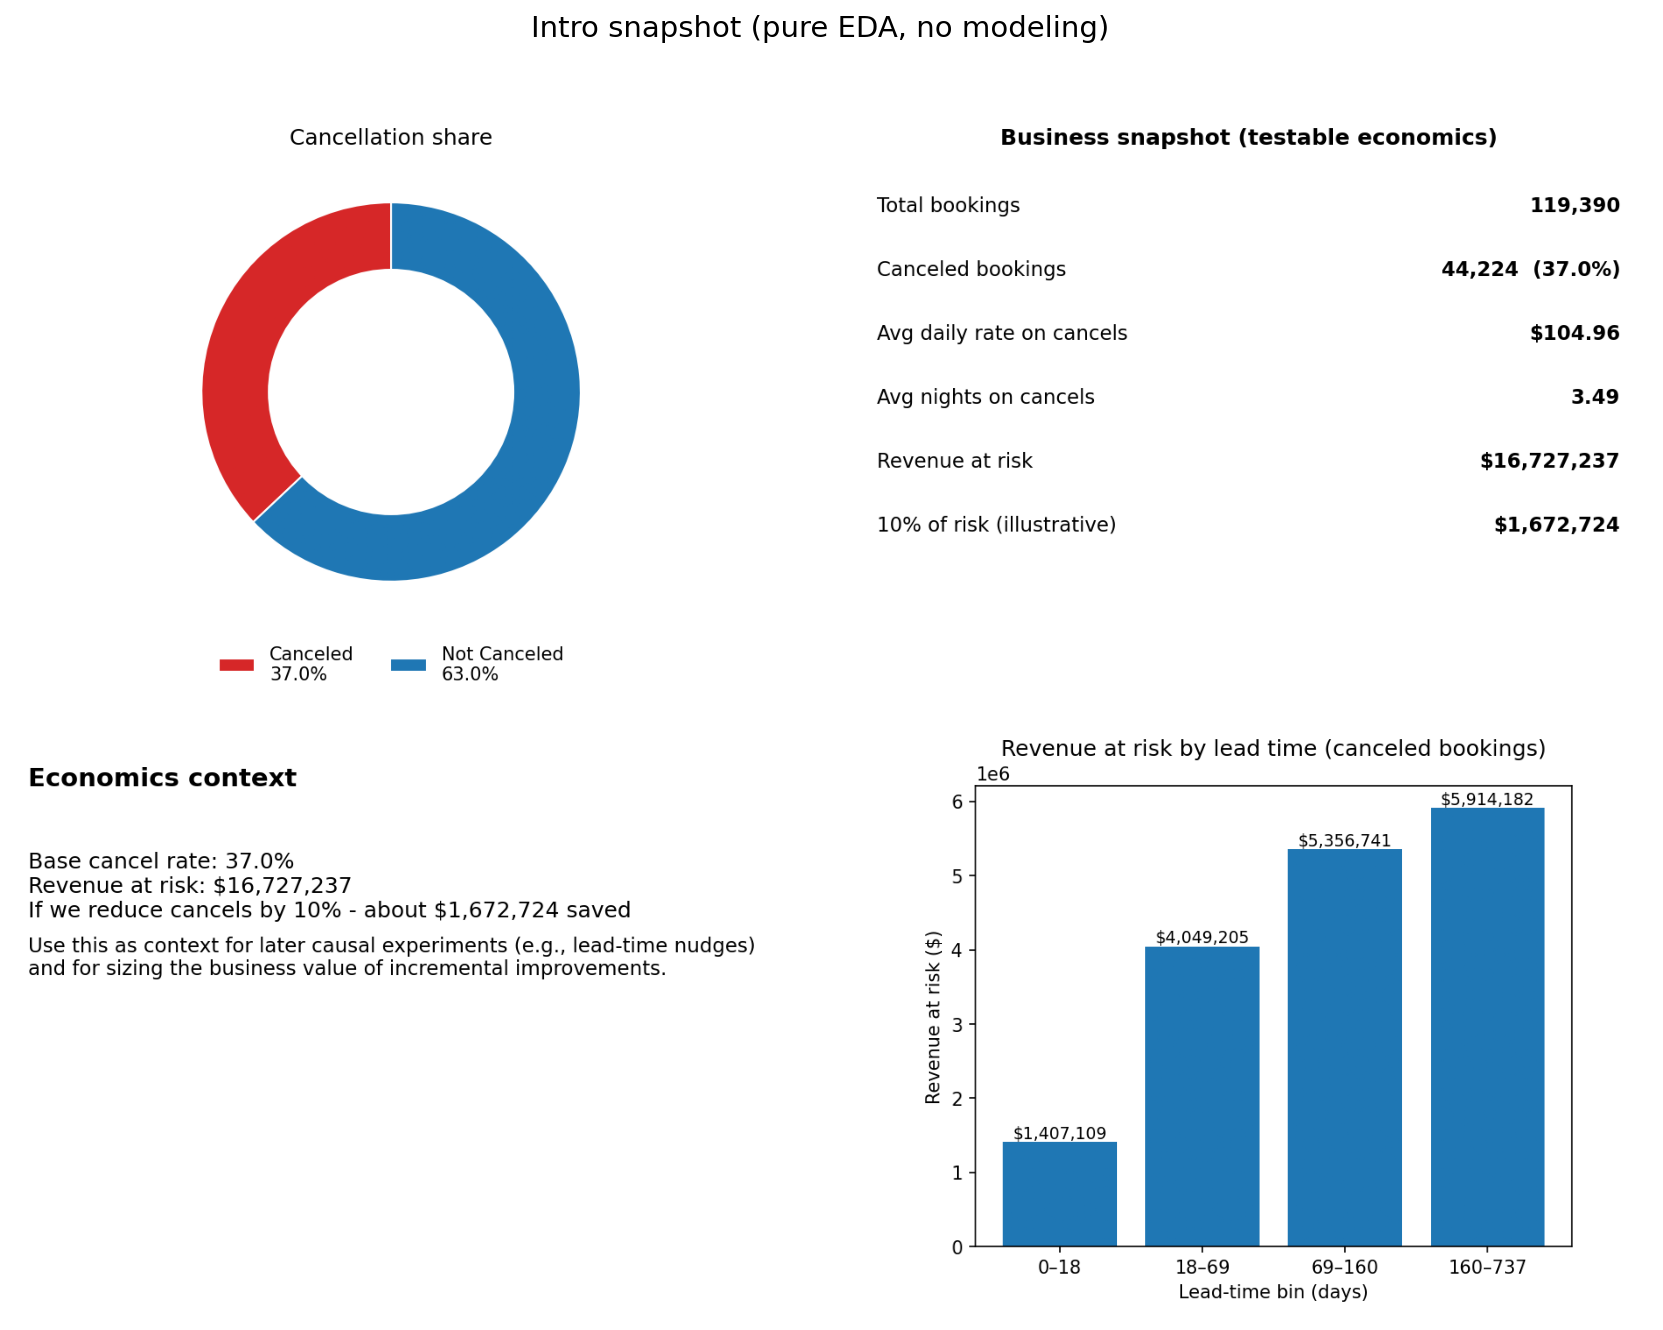

In [5]:
show_img(PLOTS_DIR / "00_intro_panel.png", width=1000)

### Preprocessing Steps
1. Dropped leakage columns such as `reservation_status`, `company`, and `agent`.  
2. Created engineered features:
   - `total_stay` = weekday nights + weekend nights  
   - `total_guests` = adults + children + babies  
   - `conversion` = 1 - `is_canceled`  
3. Handled missing values and categorical encoding using one-hot encoding.  
4. Ensured that all features used in pre-treatment models were **pre-exposure** variables.


#**Data Cleaning**

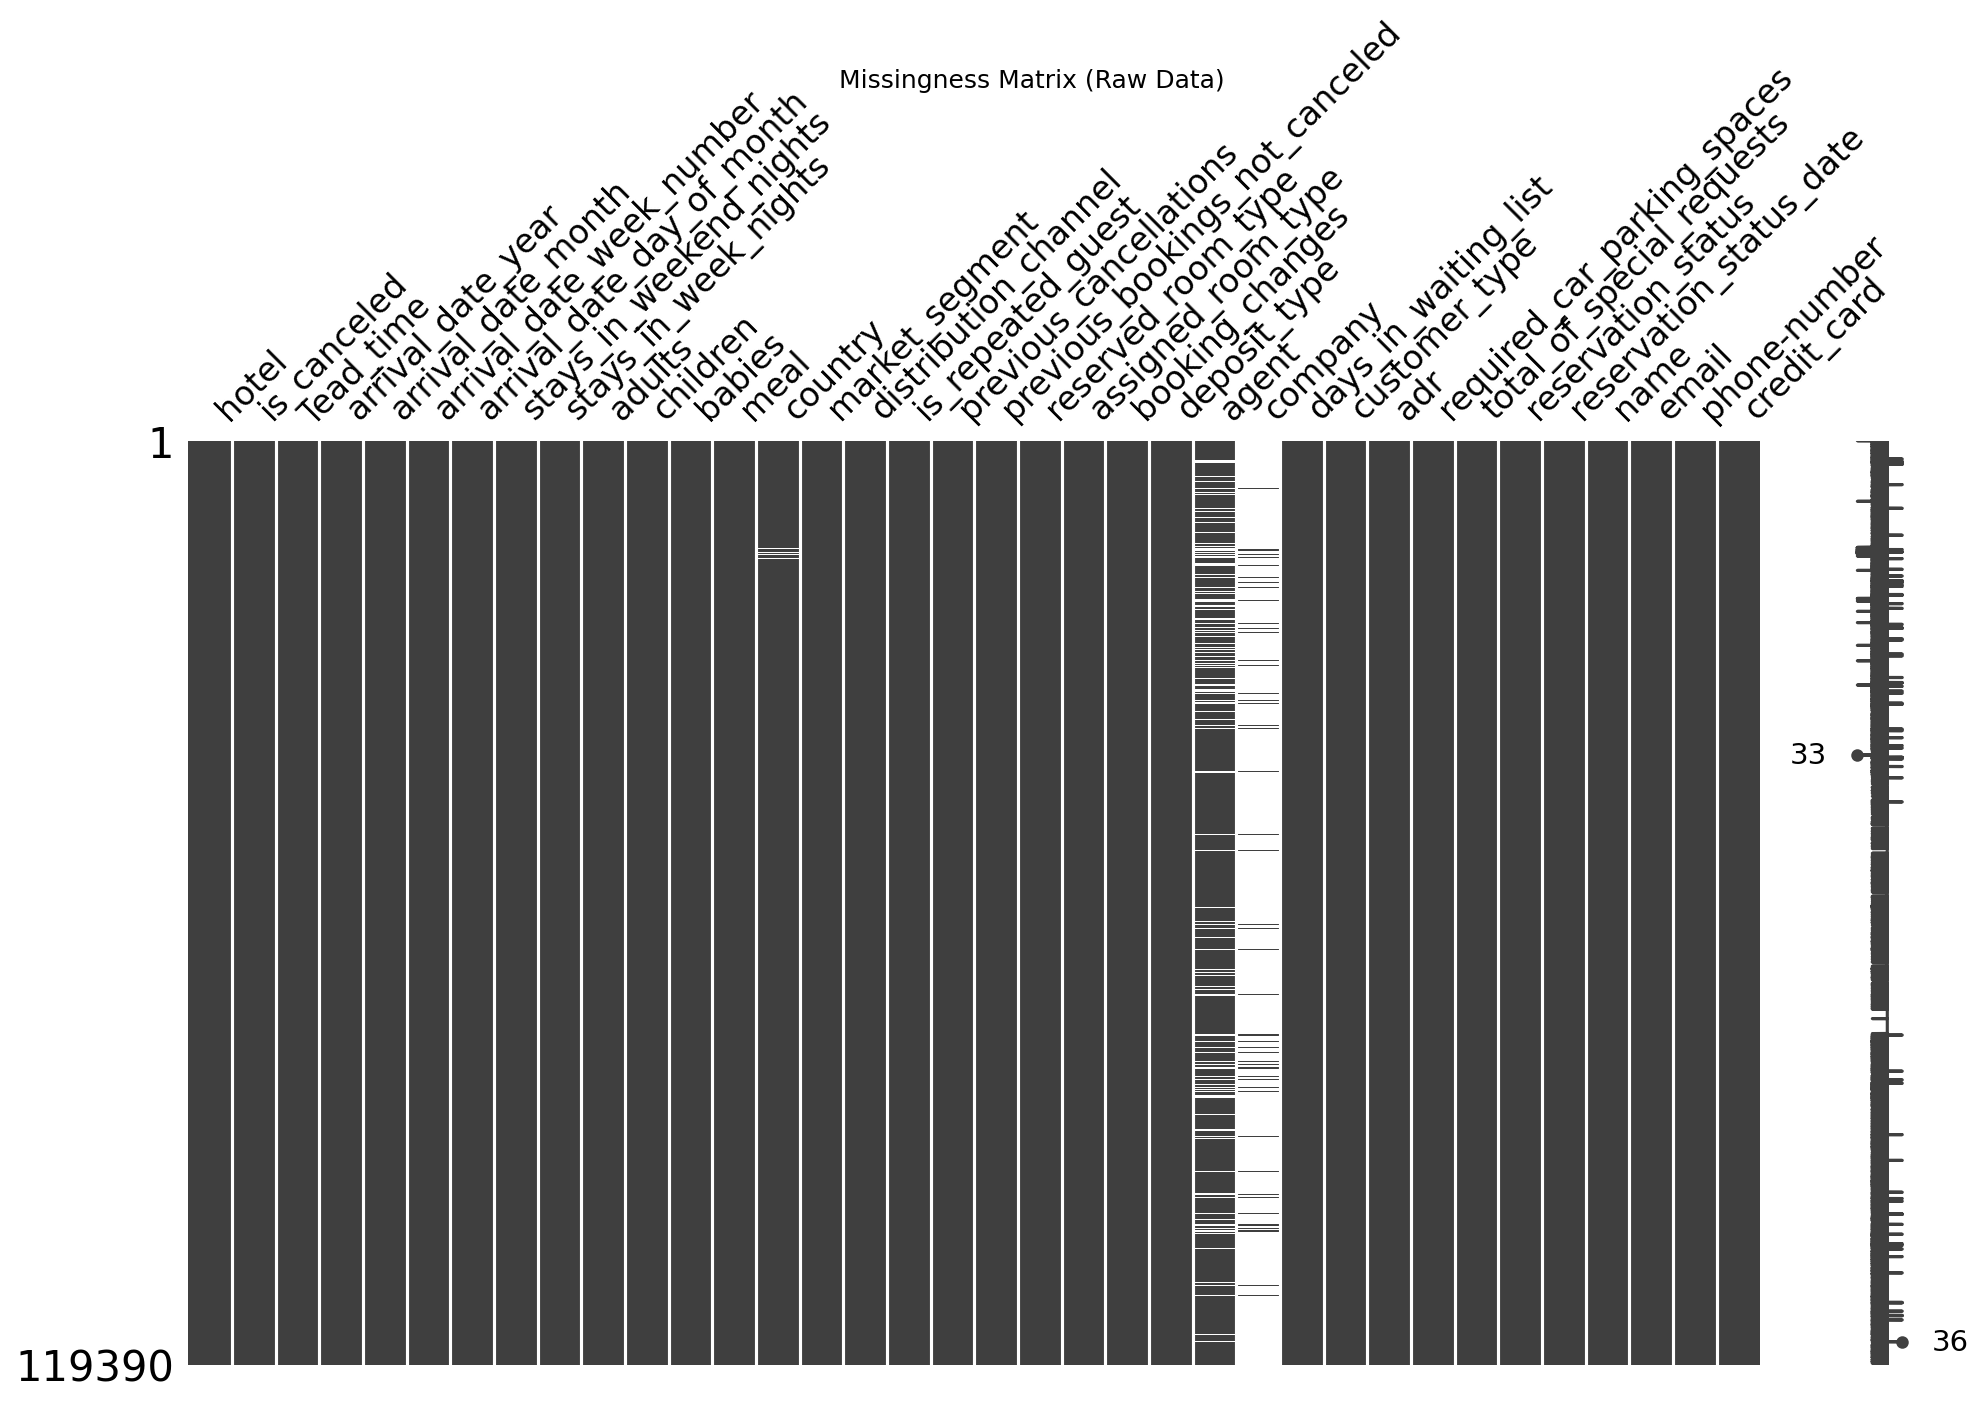

In [6]:
show_img(PLOTS_DIR / "missingness_matrix.png", width=1000)

- **Dropped high-missing columns:**  
  `company`, `agent` -- These fields contained excessive missing values and offered little predictive value.

- **Filled missing `country` values** with the mode **PRT**  
  - Prevented unnecessary row loss and maintained data consistency.

- **Engineered new features:**
  - `total_stay` = `stays_in_weekend_nights` + `stays_in_week_nights`  -- Captures total length of stay per booking.
  - `total_guests` = `adults` + `children` + `babies` -- Represents total occupancy per reservation.
  - `different_room_assigned` = (`reserved_room_type` ≠ `assigned_room_type`) -- Flags mismatches between reservation and actual assignment, a potential source of dissatisfaction.

- **Removed post-outcome leakage:**  Dropped `reservation_status`  


-----------------------------------------------------------------------------
#**Correlation Funnel**
assess correlation before causation

In [7]:
# correlation funnel
show_img(PLOTS_DIR / "correlation_funnel2.png", width=1500)


Missing: /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/correlation_funnel2.png


### Feature Insights
- **reservation_status** shows strong signals near ±1, directly encoding the outcome and causing leakage — should be dropped from modeling.  
- **deposit_type** has high positive correlations; certain types (e.g., *Non Refund*) link to higher cancellation rates.  
- **lead_time** bins show that long-lead bookings (right side) cancel more often, while short-lead bins (left side) cancel less.  

**How to read:**  
Dots on the left (≤0) indicate lower cancellation correlation; dots on the right (≥0) indicate higher correlation.  
Features are ordered by their strongest bin correlation with `is_canceled`, meaning a feature appears higher if any of its bins shows a large effect.


---
# **Model Pre-Process- Multivariate GLM: Pre-Treatment Features Only**

###**Confounding Variables (Setup)**
- Identify categorical vs numeric *(object = categorical here)*

####**Steps**
1. **Dummify** categorical variables  
2. Ensure **numeric dtypes**  
3. **Train/Test split**  
4. **Add intercept** with `sm.add_constant(X_train)`  
5. **Fit model** — GLM Binomial (logit) with **L1 (Lasso)** regularization *(alpha ≈ 0.01)*

####**GLM Notes**
- `GLM` is the statsmodels class for many regression types  
- `family=Binomial()` - binary outcome *(0/1)*  
- `link=logit()` - logistic link transforms linear scores to probabilities  
- **Elastic net penalty** helps prevent overfitting; here we **lean L1 (Lasso)** with `alpha=0.01`


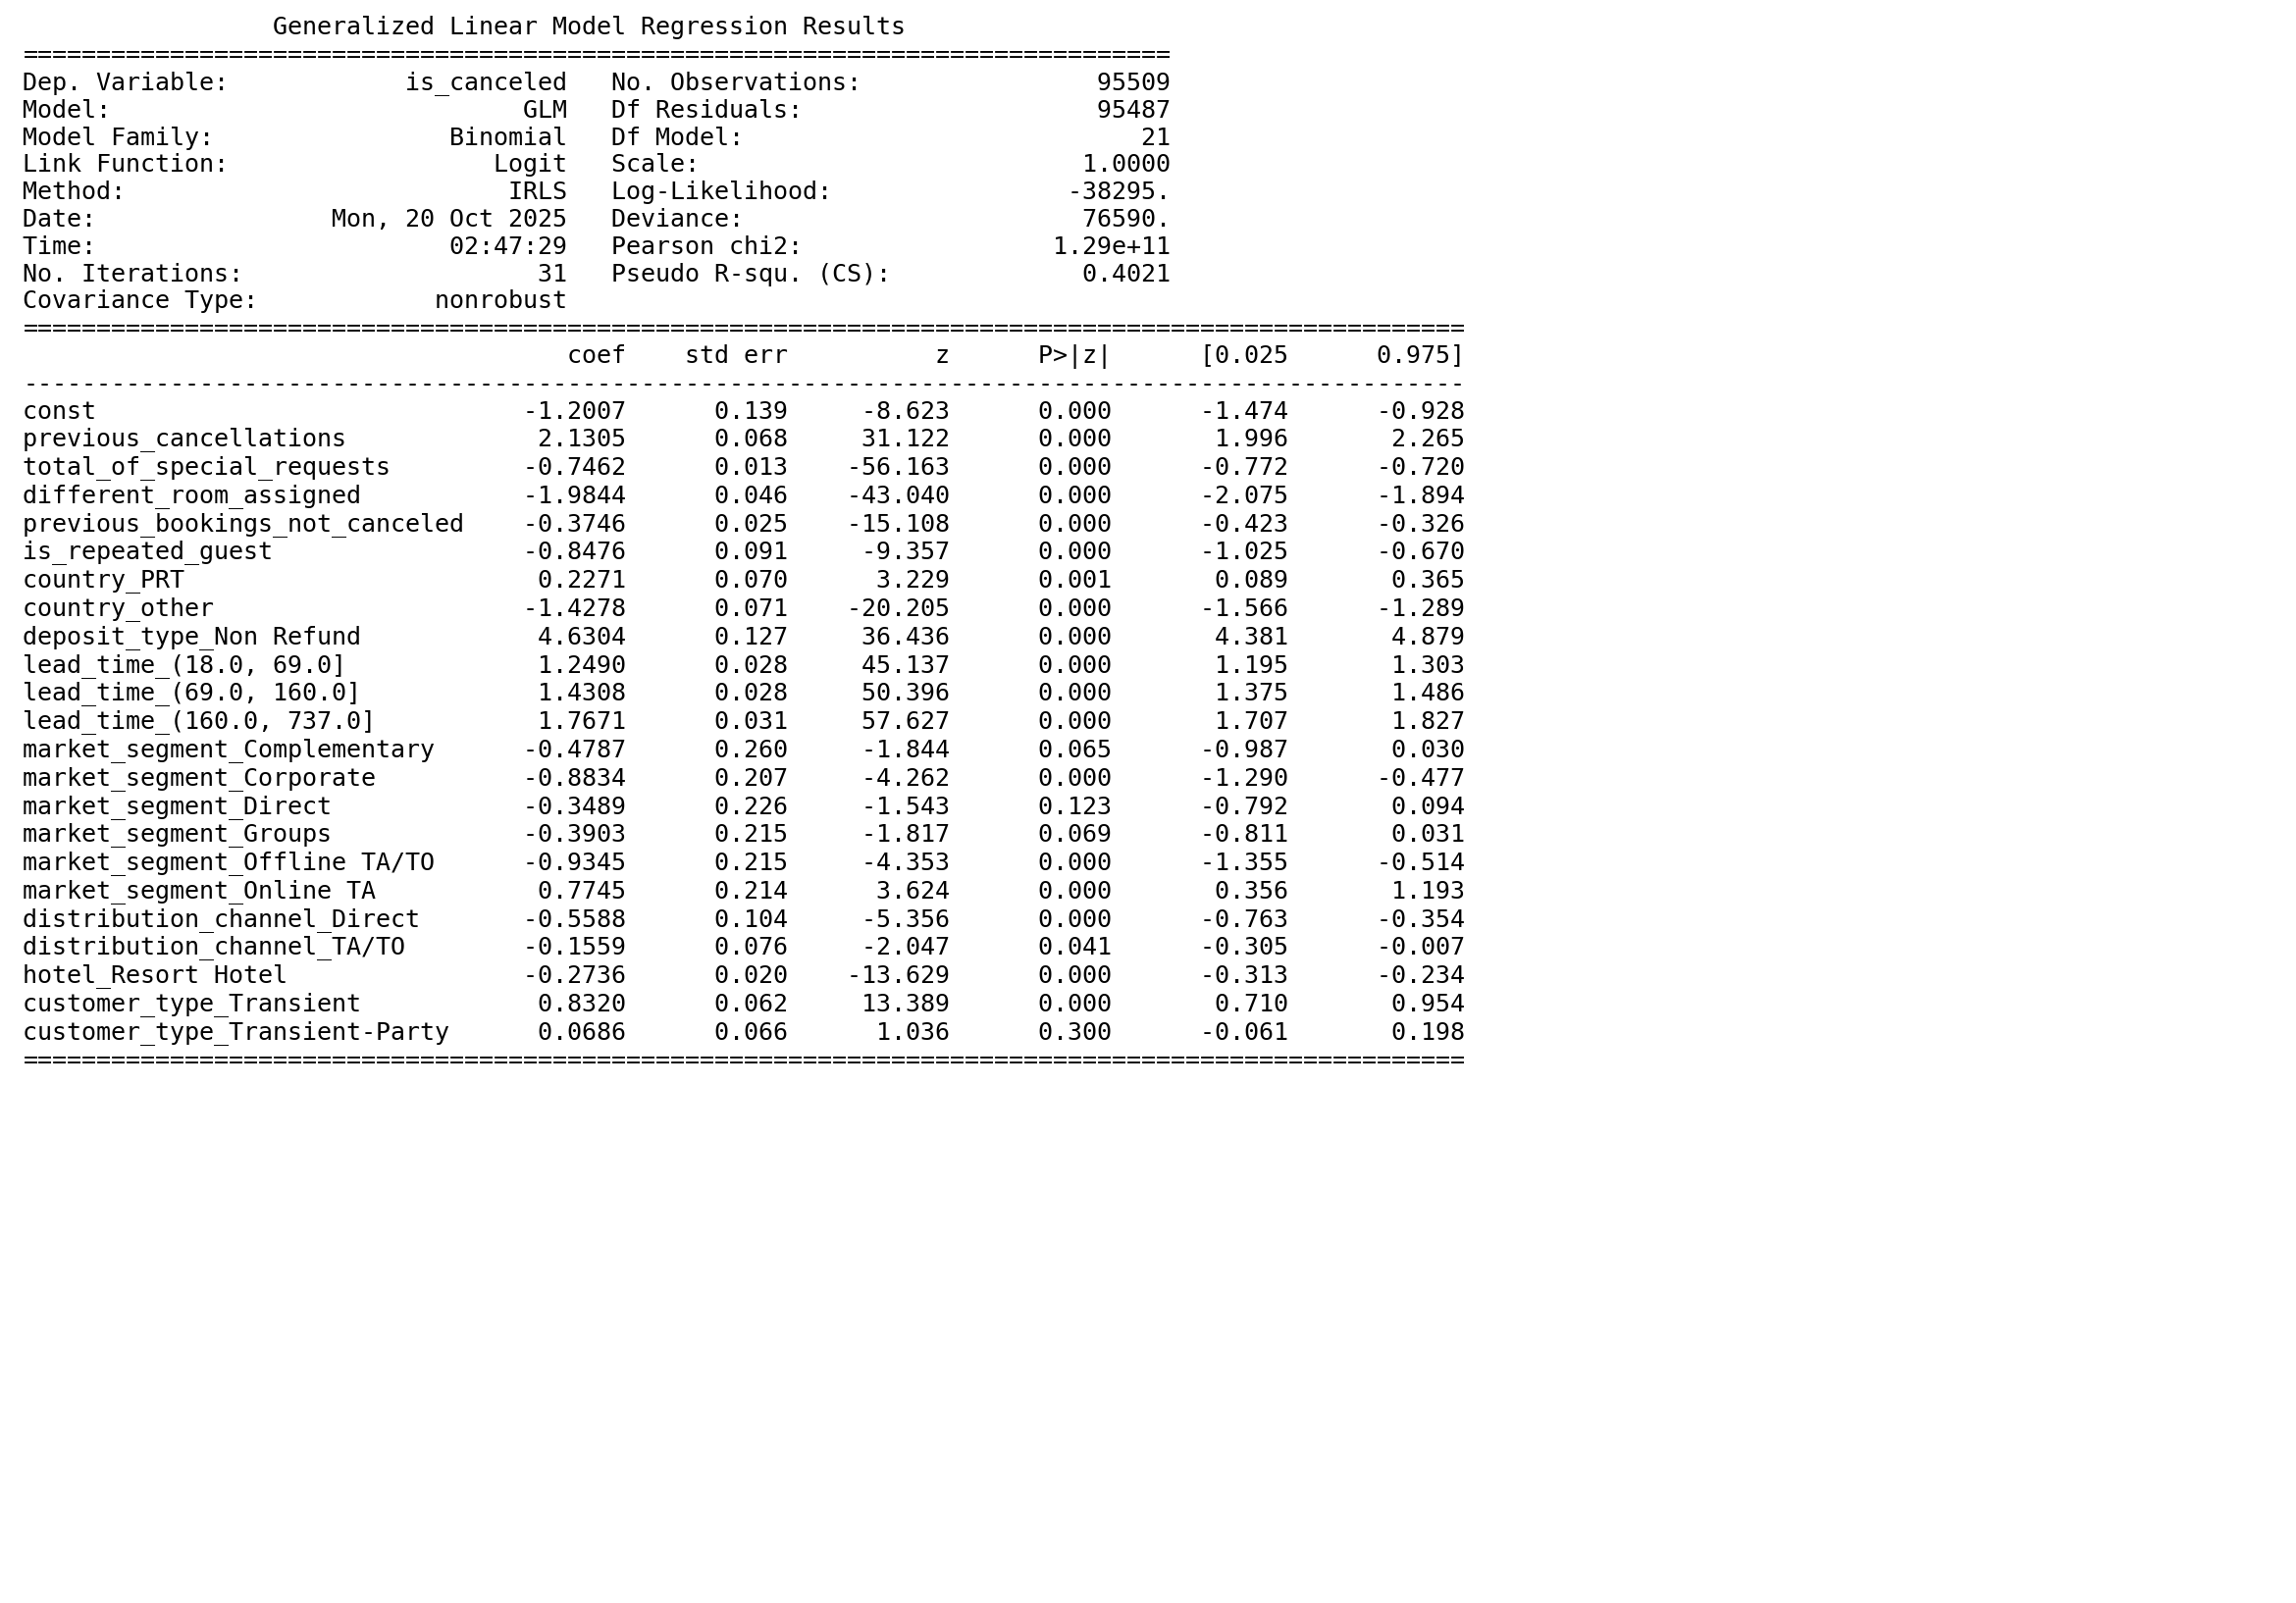

In [8]:
show_img(os.path.join(PLOTS_DIR, "glm_unpen_summary.png"), width=1200)

**Pseudo R-squ. (CS)**: 0.4021. For a tabular churn/cancel problem, that's strong for a purely pre-treatment spec.

**Columns**

coef
The estimated effect on log-odds (logit scale). Positive ⇒ higher cancel odds; negative ⇒ lower.
Convert to odds ratio with exp(coef).

std err
The standard error of the coefficient estimate (sampling uncertainty). Smaller means tighter estimate. It comes from the model's covariance estimate (yours says nonrobust). You can request robust SEs if needed.

z
Test statistic: z = coef / std_err. It measures how many SEs the estimate is from 0. 0 means no effect.

P>|z|
Two-sided p-value for testing H₀: coef = 0. Small p (e.g., <0.05) - the effect is statistically different from 0 under the model's assumptions.

[0.025, 0.975]
The 95% confidence interval for the coefficient on the log-odds scale. Exponentiate the bounds to get a CI for the odds ratio.

**Example deposit_type_Non Refund**

z & p: The estimate (4.6304) is 36 SEs away from 0 - extremely incompatible with 'no effect' - so statistically significant.

Odds ratio: exp(4.6304) = 102.5
Sentence: Holding other variables fixed, bookings with “Non Refund” have about 102.5 higher odds of cancellation than the baseline deposit type.

OR 95% CI: exp(4.381) ≈ 79.6, exp(4.879) ≈ 131.5
Sentence: A plausible range for that odd ratio  from 80 to 132.

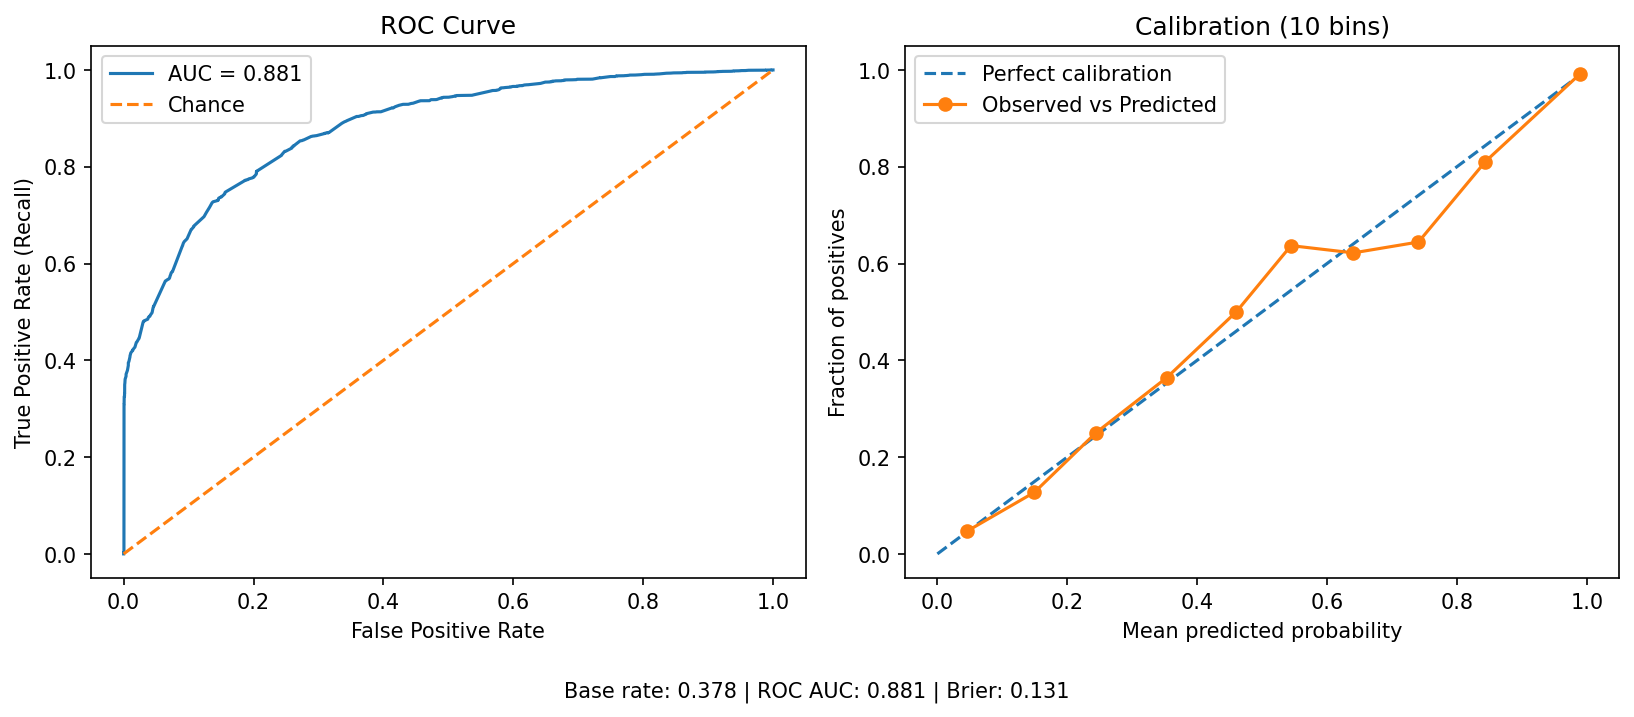

In [9]:
show_img(os.path.join(PLOTS_DIR, "roc_and_calibration_panel.png"), width=1000)

**ROC curve**— discrimination. The model ranks likely cancellations well: AUC 0.881 (0.50 = random, >0.80 = good). This means, across thresholds, a canceled booking is much more likely to receive a higher score than a non-canceled one.

**Calibration plot**

Calibration — probability accuracy. Predicted probabilities closely match observed cancellation rates across bins (points near the 45° line). Brier 0.131 vs a naïve “always predict base rate” score of ~0.235, indicating well-calibrated risk estimates suitable for cost/benefit decisions.


# **Causal Experiment and Design**

### **Big variables to explore:**

Deposit_type Non-Refund (OR ~103x): huge selection + major commercial side-effects; not a clean knob for a first causal pass.
 - but has a lot of confounding variables:
    - Traveler intent: last-minute plans vs. far-in-advance planners; business vs. leisure; locals vs. international.
    - Price sensitivity: many non-refund offers are cheaper - attracts a different mix of guests.
    - Channel: OTAs/promotions often push non-refund; channels differ in customer behavior and cancellation norms.
    - Timing/season: during peaks, properties list more non-refund inventory.

Previous_cancellations: past behavior, not manipulable.

Do groups tend to cancel more? (the plot shows that groups do tend to cancle more but limiting reservation numbers might negativitly impact how much revenue is spent when large groups of people do come) - not good for marketing - out of our control

### Lead - times : strong candidate for causal experiment

--------------------------------------------------------------------------------

# ***4.0 Causal Hypothesis***

Question to explore:
-  **Will reducing lead time reduce cancellation? (with in our control)**

Actionable & manipulable

it can be moved with policies: limited booking window, “book-later” discounts, reminder nudges, waitlist releases ...


##**Univariate: lead_time**

###Simple Logistic Model For only Lead Time Column --- univariate model—just lead time


### BASELINE PREDICTIVE SANITY CHECKS (no causal claims)
------------------------------------------------------------
Goal: get a feel for signal using *pre-treatment* features only.
Notes:
- Univariate logistic on binned lead_time (interpretable).
- Multivariate GLM (Binomial logit) with regularization (L1) to avoid overfit.


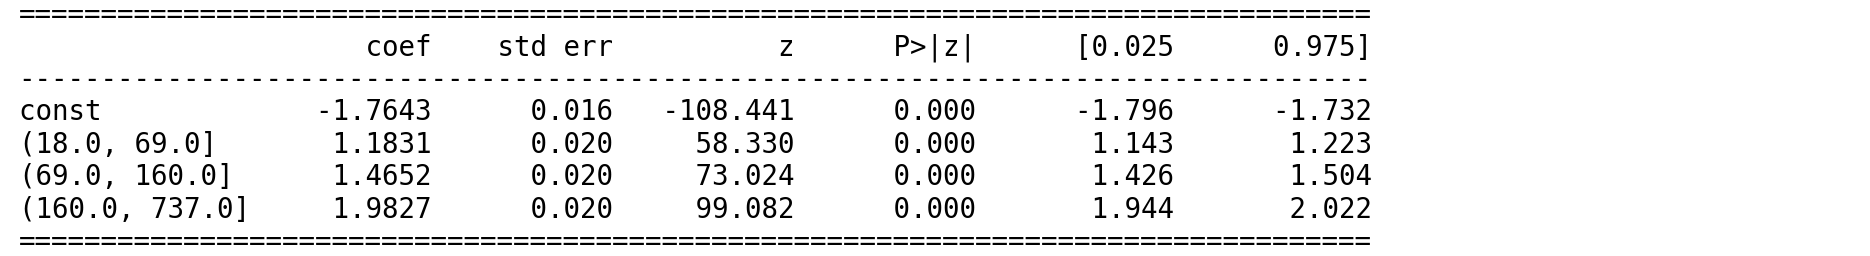

In [10]:
show_img(os.path.join(PLOTS_DIR, "leadtime_logit_coeff_table.png"), width=1200)

Reading the Log-odds numbers:

const = -1.7643 is the intercept: the log-odds of cancelation for the baseline bin (lead time in the lowest quartile, about 0-18 days). Convert to probability:

p=1/(1+e^(-(-1.7643))) = 0.146 meaning there is about 14.6% percent of cancle rate in the first 0-18 days of lead time.

Each lead-time bin coef is added to the intercept:

Big picture: compared to short lead times (baseline ~14.6%), longer lead times sharply raise cancel probability. (Note the model is univariate here—just lead time—so add other features to control for confounders. The pseudo 𝑅 2 R 2 of 0.077 shows modest explanatory power.) (Interpretation: ~7.7% improvement over an intercept-only model = small explanatory power (expected, since this model uses lead_time only))

### **Experiment**
Evaluate whether **offering a 10% discount** to *eligible guests* (e.g., Groups with long lead times) **reduces cancellations** and **increases value** versus control.

# **Post-Treatment Analysis (Notebook 02) — Report Cells**

## **A. Experiment Overview**

- **Targeting rule:** *Market Segment = Groups* AND *lead time > 90 days*  
- **Treatment:** 10% discount (avg spend \$1,500 → cost \$150 if guest converts)  
- **Population window:** 19,811 eligible guests  
- **Randomized test:** 500 guests (250 control, 250 treatment)

**Questions**
- 1) What was the effect on **cancellations/conversions**?  
- 2) What is the **ROI / \$ impact**?




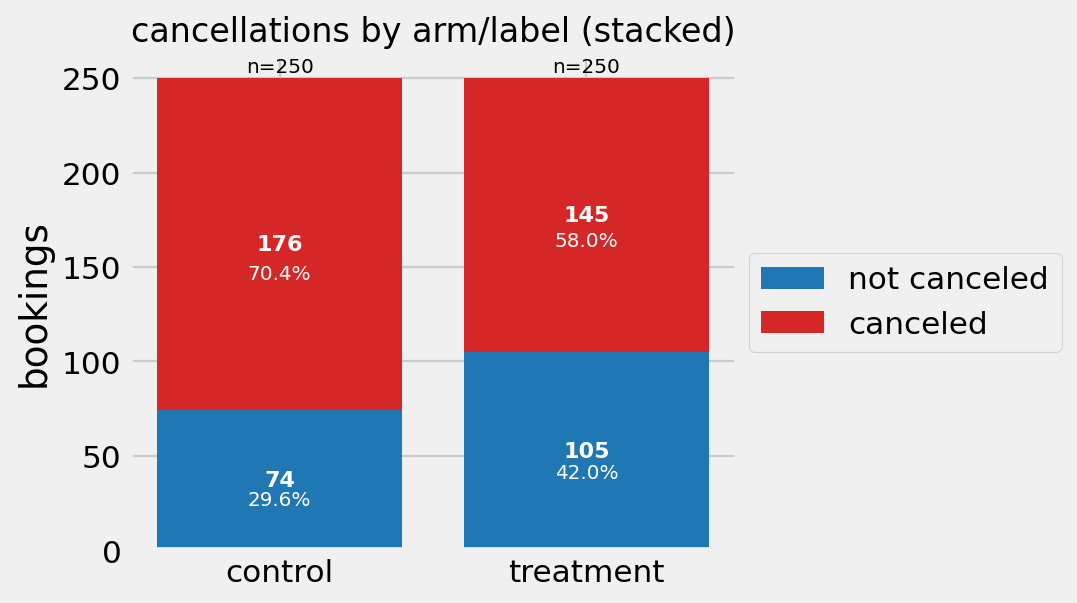

In [11]:
# Arm outcomes (stacked) — cancellations vs not canceled
show_img(os.path.join(PLOTS_DIR, "exp_cancellations_stacked_control_vs_treatment.png"), width=700)


# **B. Core Causal Estimands (ITT, CACE/LATE, Value-ITT)**

- **ITT (intent-to-treat):** difference in conversion/cancellation rates by **assignment**.  
- **CACE / LATE:** effect among **compliers** via Wald IV (assignment → acceptance).  
- **Value-ITT:** mean \$ **per assigned guest** (treatment − control), discount cost only if convert.


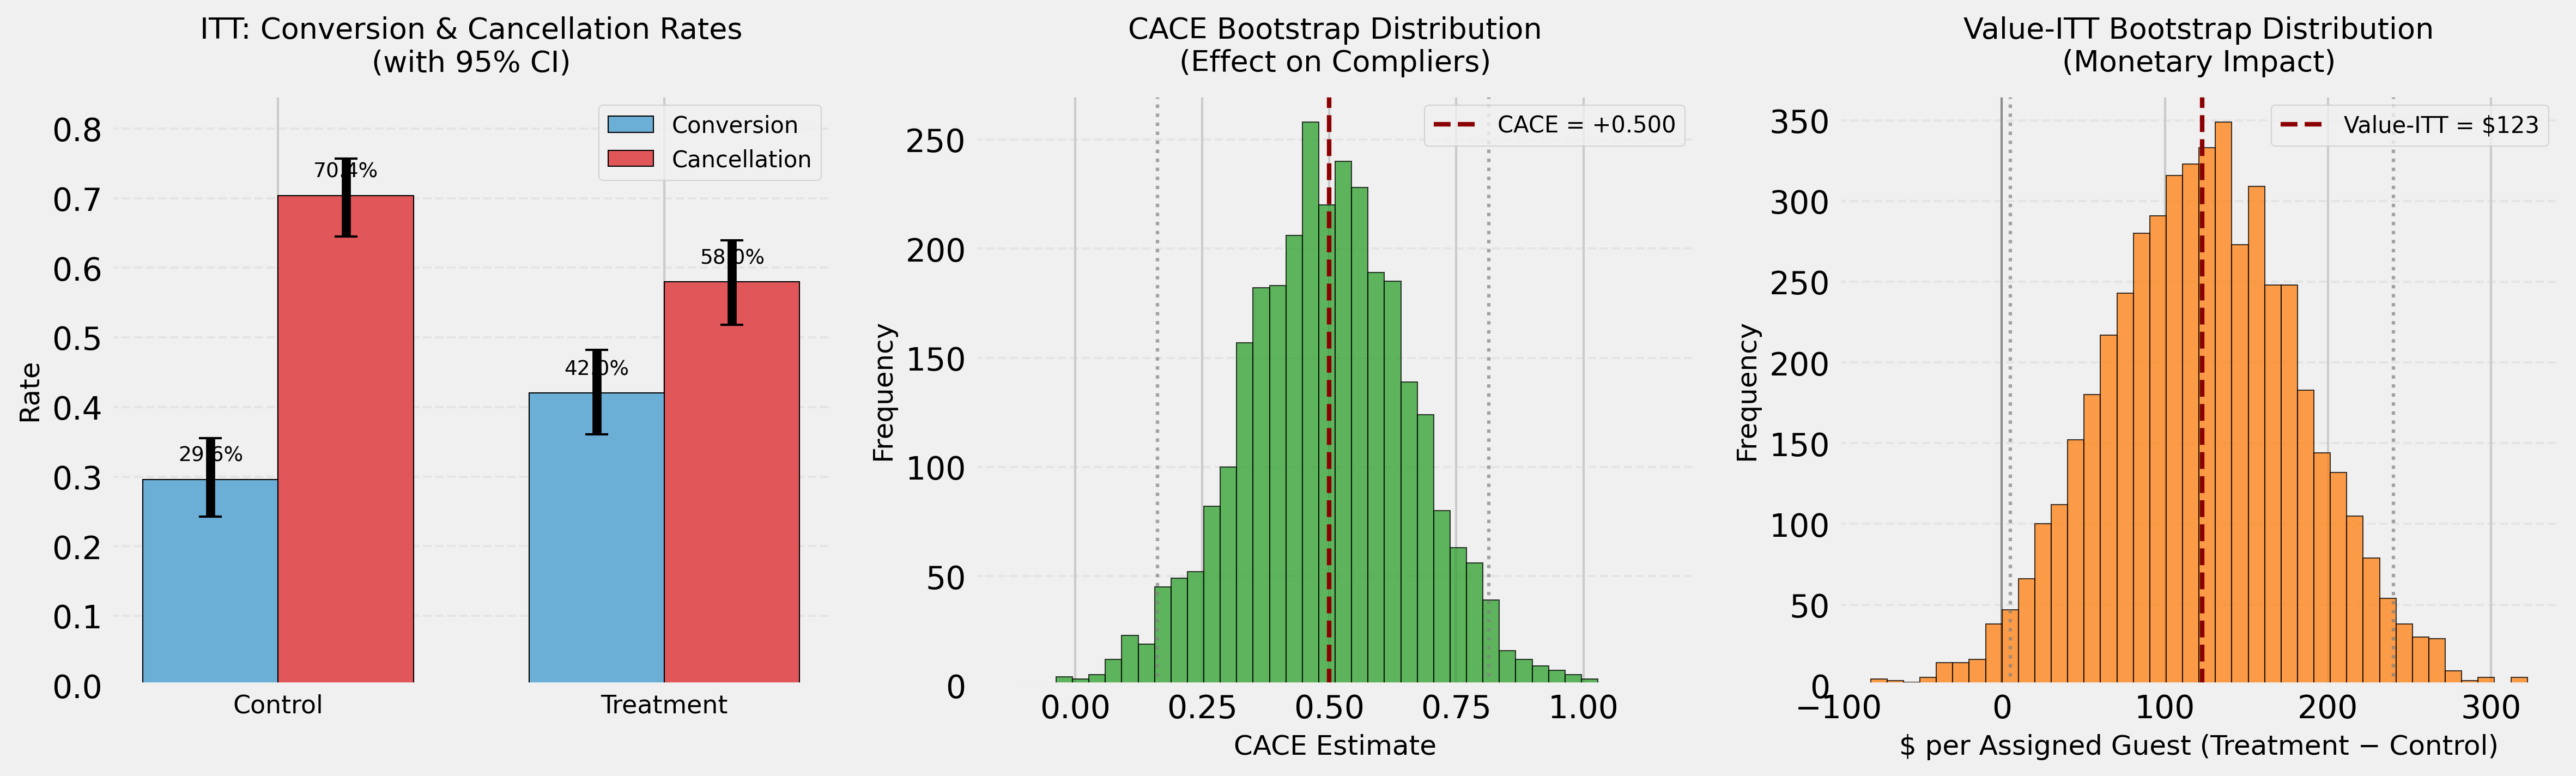

In [12]:
# ITT bars, CACE bootstrap, Value-ITT bootstrap
show_img(os.path.join(PLOTS_DIR, "causal_estimands_summary.png"), width=1400)

### ITT (Intent-to-Treat)
- Conversion ITT = P(kept | treatment) - P(kept | control)  
  Conversions increased by 12.4 percentage points (42.0% vs 29.6%).  
- Cancellation ITT mirrors this decrease by 12.4 percentage points (58.0% vs 70.4%).  
- Error bars (95% CI) show little overlap, indicating statistically meaningful differences.

### CACE (Complier Average Causal Effect)
- Estimate: +0.50  
  Guests who accepted because they were offered kept their bookings about 50 percentage points more often.  
- 95% CI: +0.162 to +0.814 (bootstrap, 3,000 draws), Positive and substantive.

### Value-ITT
- Mean gain: \$123 per assigned guest.  
- 95% CI: $5 to \$240 (bootstrap), with most of the distribution above zero.

### Takeaways
- Conversion up and cancellations down with clear confidence separation.  
- Strong positive effect among compliers.  
- Positive average dollar impact per assigned guest.

--------------------------------------------------------------------------------

# **C. Uplift Modeling — Who to Treat?**

### **C1. Uplift Tree (Rule-based Segments)**
- Splits maximize treated vs control **conversion divergence**.  
- Read nodes: *split rule*, *samples*, *group samples*, *uplift*, *p-value*, *means by arm*.  
- Actionable summary from train side:
  - **Treat**: refundable/no-deposit **and** long lead time (e.g., `new_lead_time ≥ 134`).  
  - **Avoid**: `Non Refund` + mid-long lead ranges showing **negative** uplift.


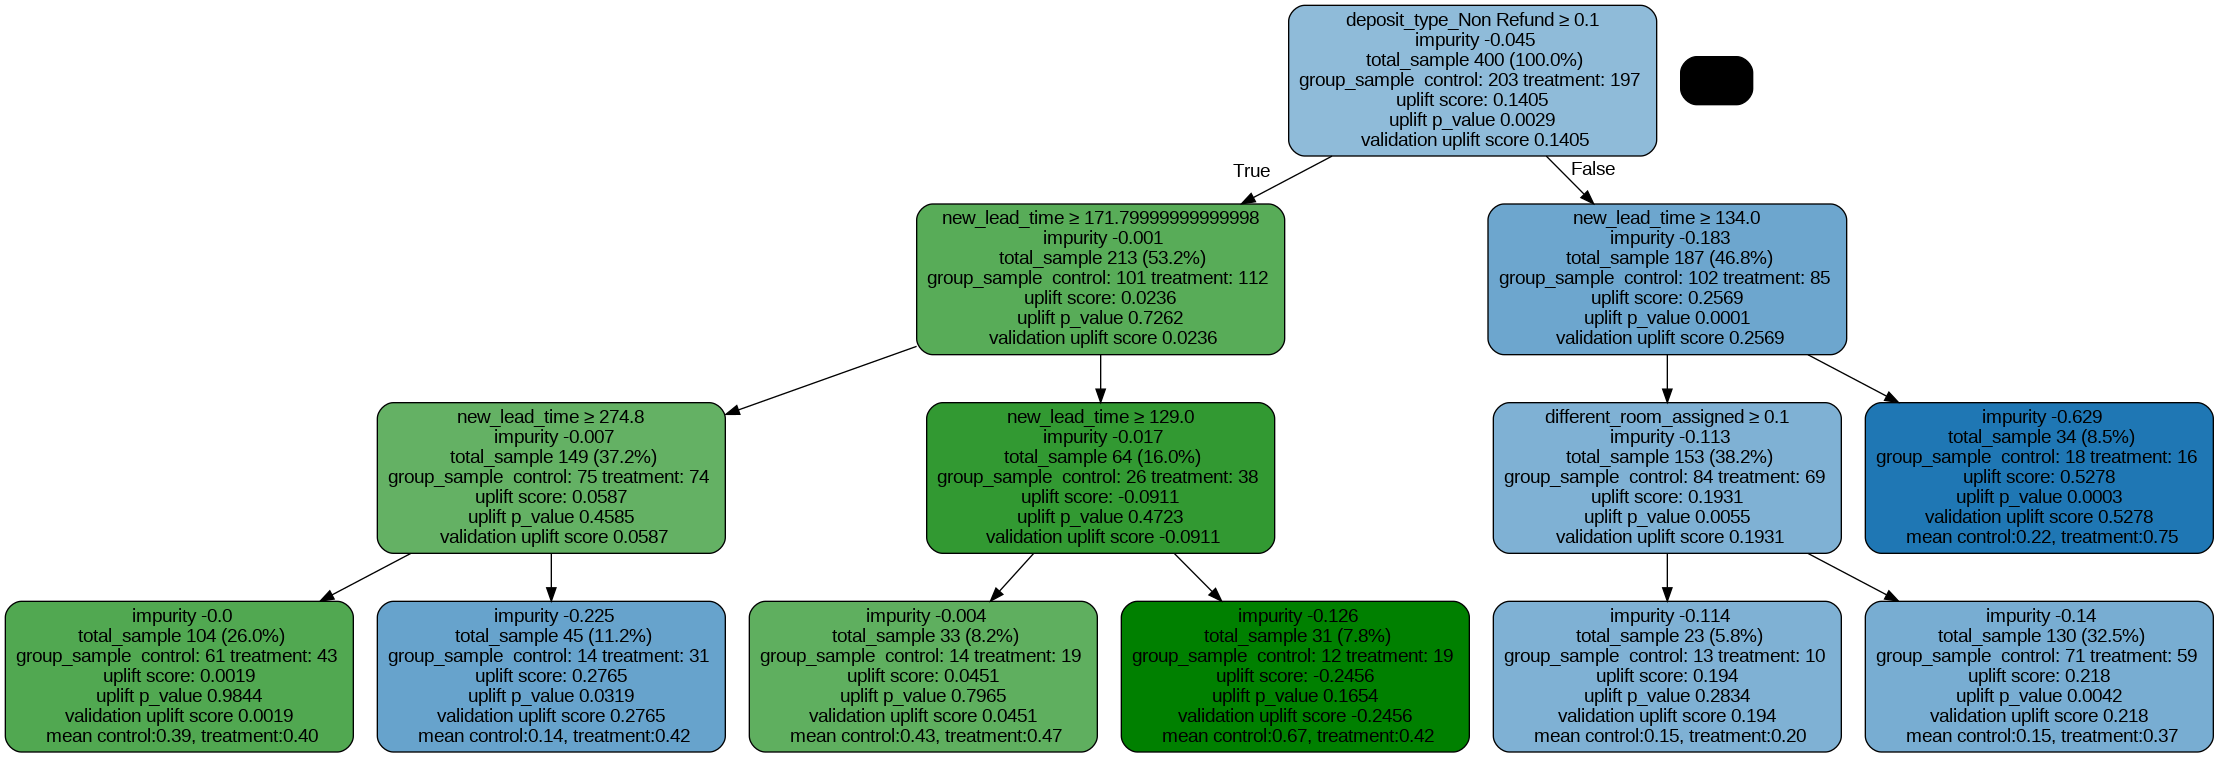

In [13]:
# Uplift tree (structure)
show_img(os.path.join(PLOTS_DIR, "uplift_tree.png"), width=1500)


### What the tree finds
- **Root split:** Non-Refund vs everything else (Refundable/No-Deposit), with clear differences.
- **Right branch (Refundable/No-Deposit):**  
  - `new_lead_time ≥ 134` → strong treat segment (n=187, uplift ≈ +0.257, p ≈ 0.0001).  
  - Further split on `different_room_assigned`:
    - Larger leaf n=153, uplift ≈ +0.193 (stable).
    - Small leaf n=34, very high uplift but tiny sample and possibly post-treatment.

- **Left branch (Non-Refund):**  
  - Mixed or weak positives; one segment negative (uplift ≈ −0.091, n=64).  
  - Small positive leaves exist but sample sizes are small.

### Actionable rules
- **Treat:** `deposit_type != "Non Refund"` **and** `new_lead_time ≥ 134` (notably the n=153 leaf, uplift ~ +0.19).
- **Avoid:** `deposit_type == "Non Refund"` **and** `129 ≤ new_lead_time < 171.8` (negative uplift).

### Caveats
- Very small leaves are high variance; interpret with caution.
- `different_room_assigned` may be post-treatment depending on when it is recorded; consider excluding to prevent leakage.

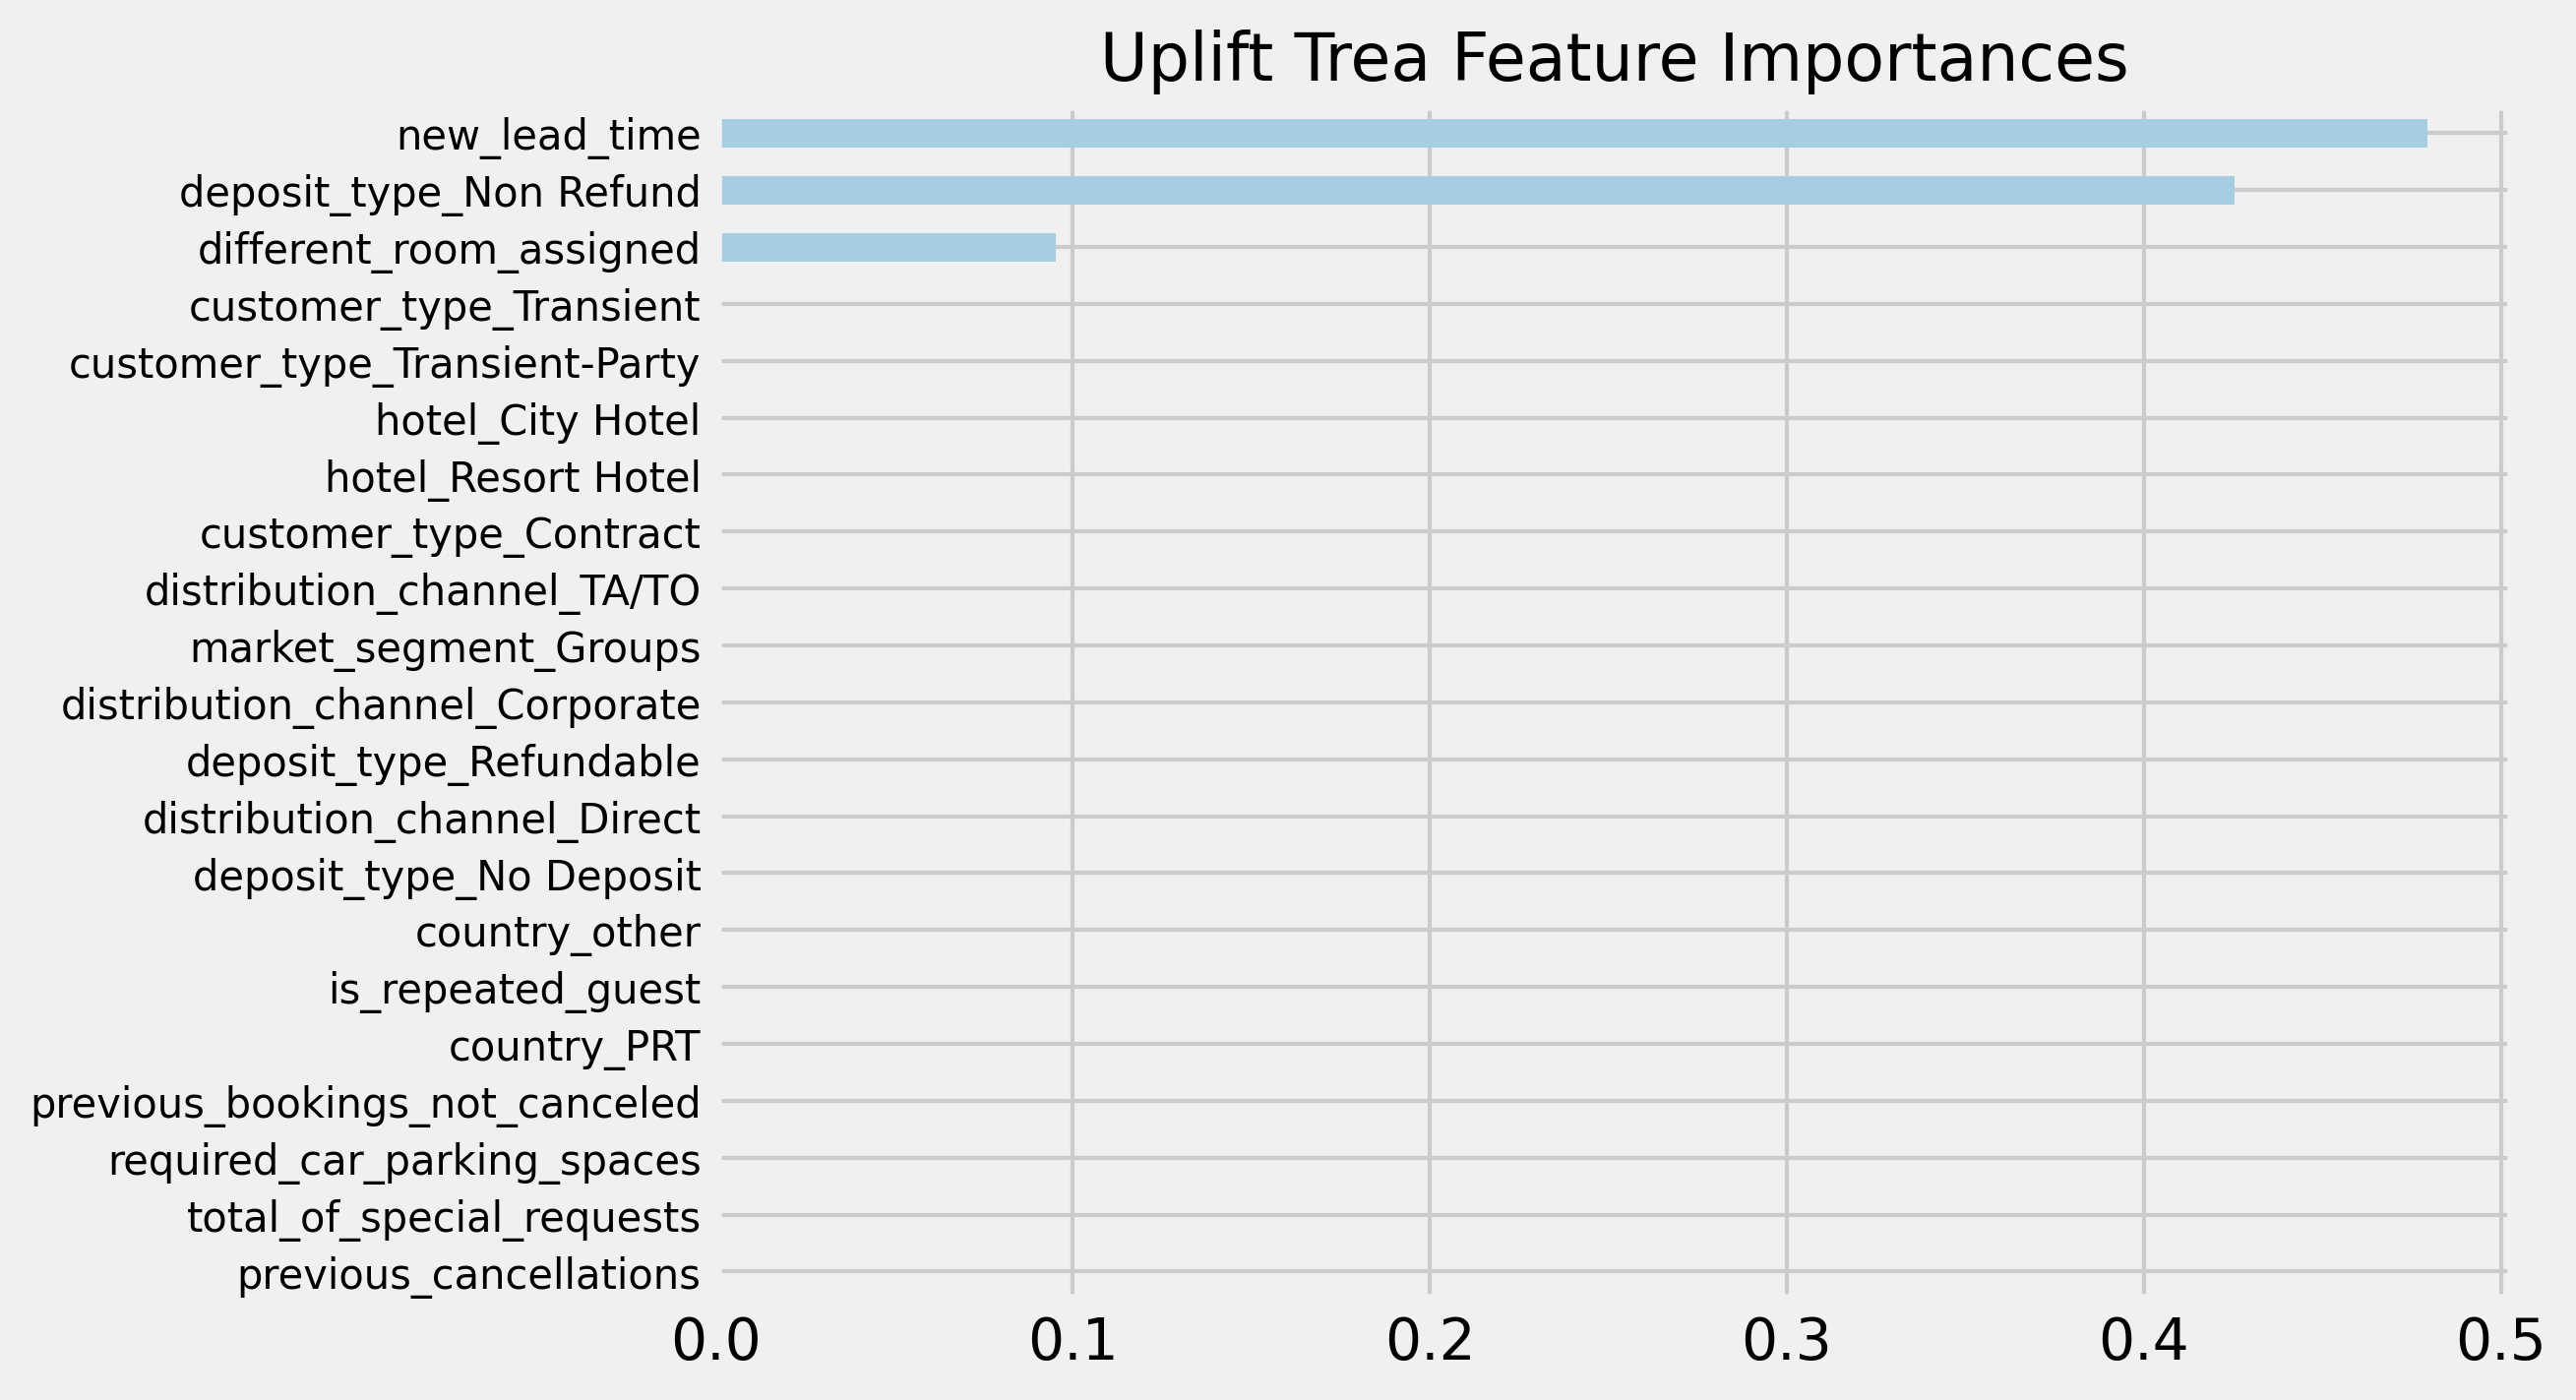

In [14]:
# Uplift tree feature importances
show_img(os.path.join(PLOTS_DIR, "uplift_tree_importances.png"), width=800)


`new_lead_time` and `deposit_type_Non Refund` dominate split logic.


## **C2. S-Learner (LightGBM) — Smooth Heterogeneity**
- Single model learns baseline risk + treatment interaction.  
- Importances & SHAP explain **uplift (τ̂)** drivers (not just conversion).
- Create an S-learner wrapper - simple and strong for tabular data: one model learns both baseline risk and how treatment changes it.
- LightGBM handles non-linearities & interactions (e.g., lead_time x deposit_type) and works well with one-hot features.


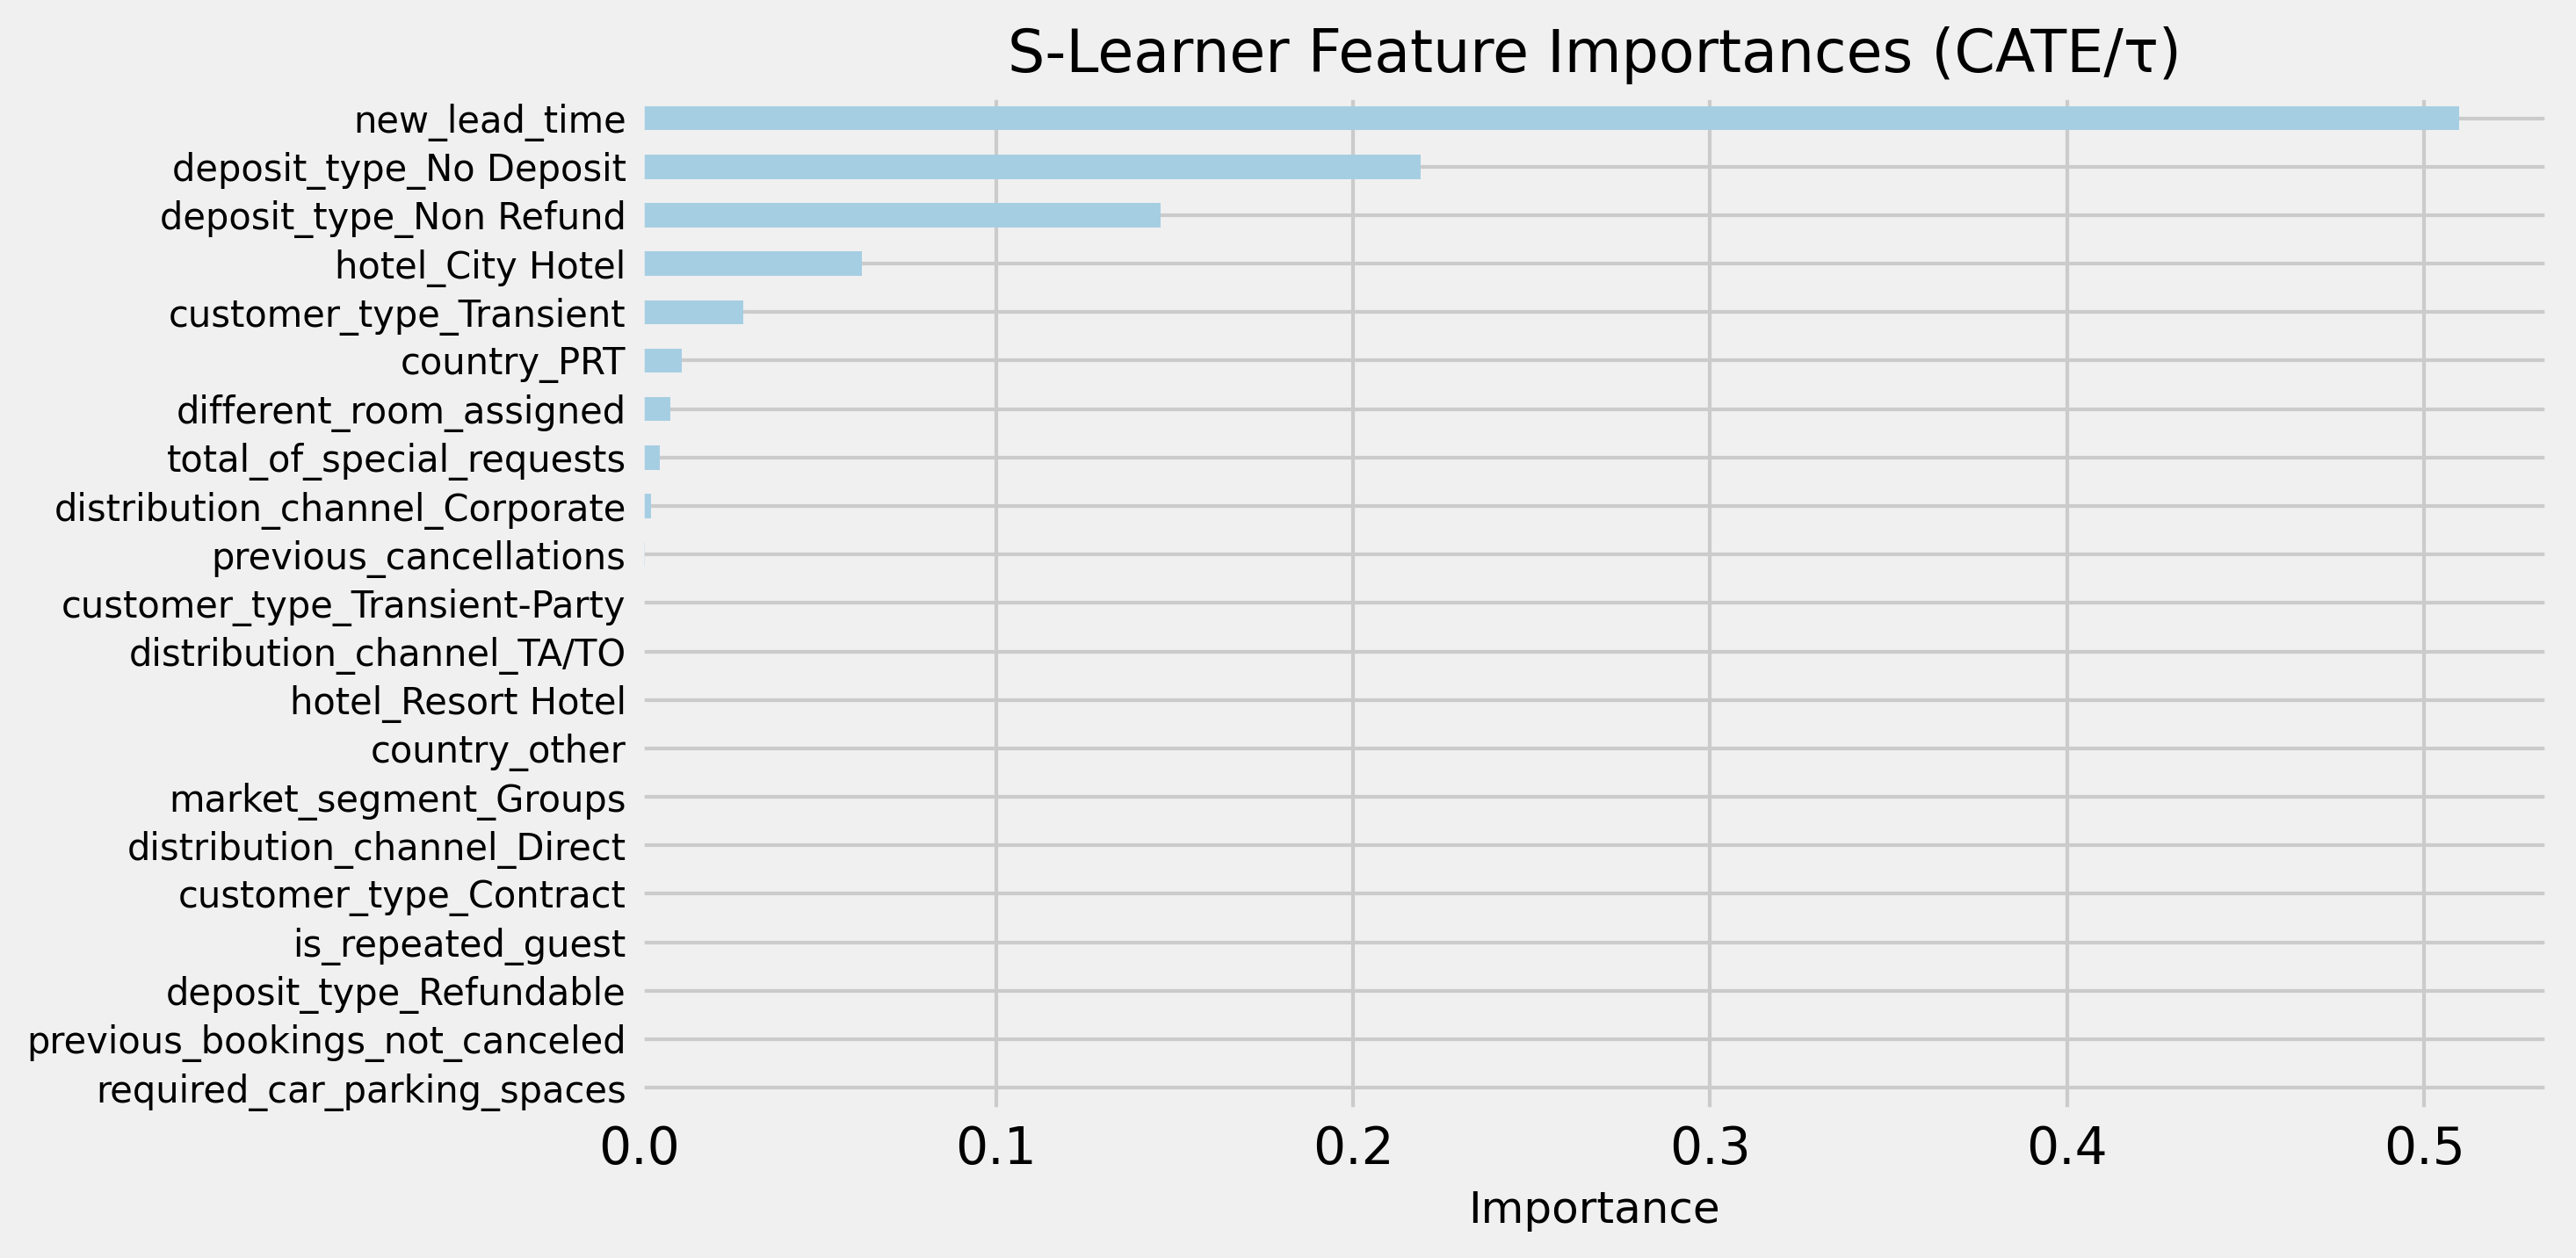

In [15]:
# S-Learner uplift (τ) feature importances
show_img(os.path.join(PLOTS_DIR, "slearner_tau_importances.png"), width=900)


### S-learner feature importance (for CATE/τ - Conditional Average Treatment Effects )
- Bars show which features most change the **treatment effect** (uplift), not baseline conversion.

### Reading CATE (τ) per guest - We want to know **which features make τ vary across people**.
- **τ > 0:** the offer **increases** this guest's probability of keeping the booking (size = how much).
- **τ ≈ 0:** little or no expected impact.
- **τ < 0:** the offer **reduces** the keep probability (avoid offering).
- τ is an **individual-level** estimate: “by how many percentage points would this guest's keep rate change if offered?”


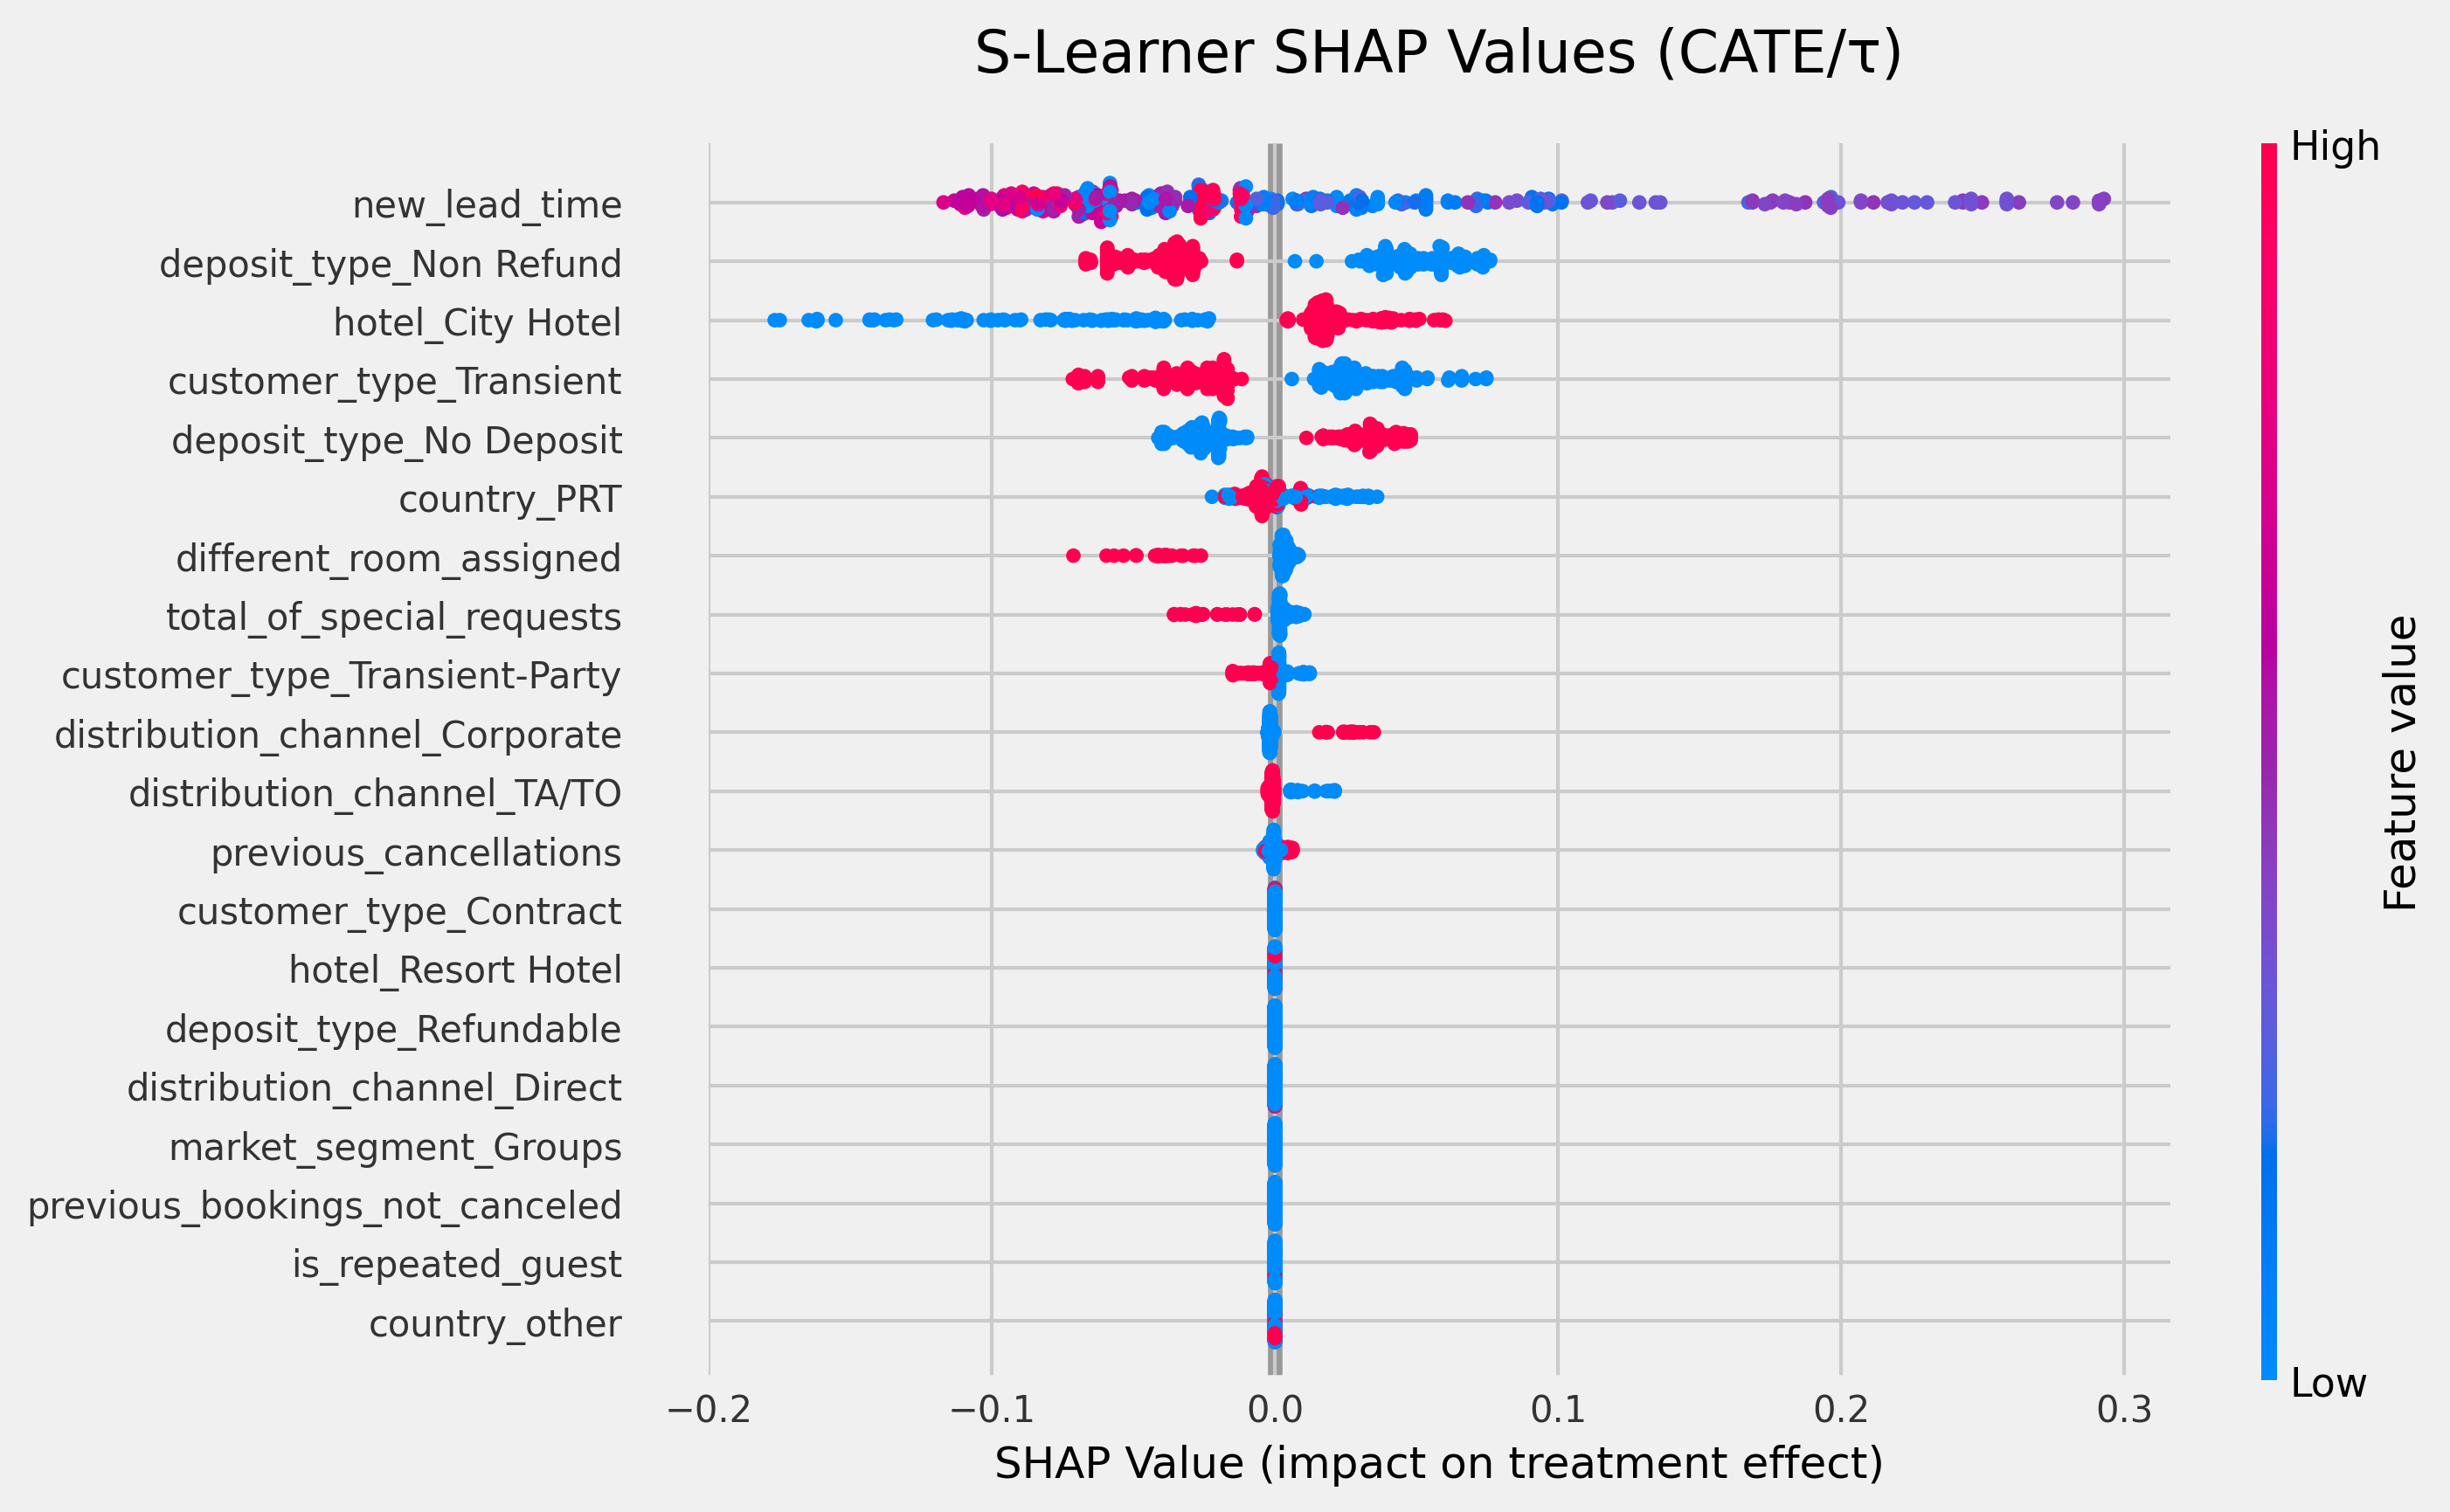

In [16]:
# SHAP summary (uplift): which features push τ̂ up/down
show_img(os.path.join(PLOTS_DIR, "slearner_shap_values.png"), width=900)


### How to read the SHAP (uplift) summary
- Each dot = one booking; each row = one feature (all 500 bookings).
- X-axis: SHAP value for uplift (how much that feature moves the **treatment effect** for that booking).
  - **Right of 0**: increases predicted uplift (offer helps more). **Left of 0**: decreases predicted uplift (offer helps less or may hurt).
- Color = the feature's value for that dot:
  - **Blue/Purple**: low value (e.g., short lead time, category = 0). **Red/Pink**: high value (e.g., long lead time, category = 1).
- Features are ordered by overall impact on uplift.

### What it shows here
- **new_lead_time**: Mid-range lead times have the largest positive uplift; very long lead times trend lower or negative. Some short lead times still show small positive uplift.
- **deposit_type_Non Refund**: Non-Refund is associated with lower or negative uplift; refundable/no-deposit drives positive uplift. Treat refundable, avoid non-refund.
- **hotel_City Hotel**: City-hotel bookings lean positive on uplift; non-city bookings show less benefit.


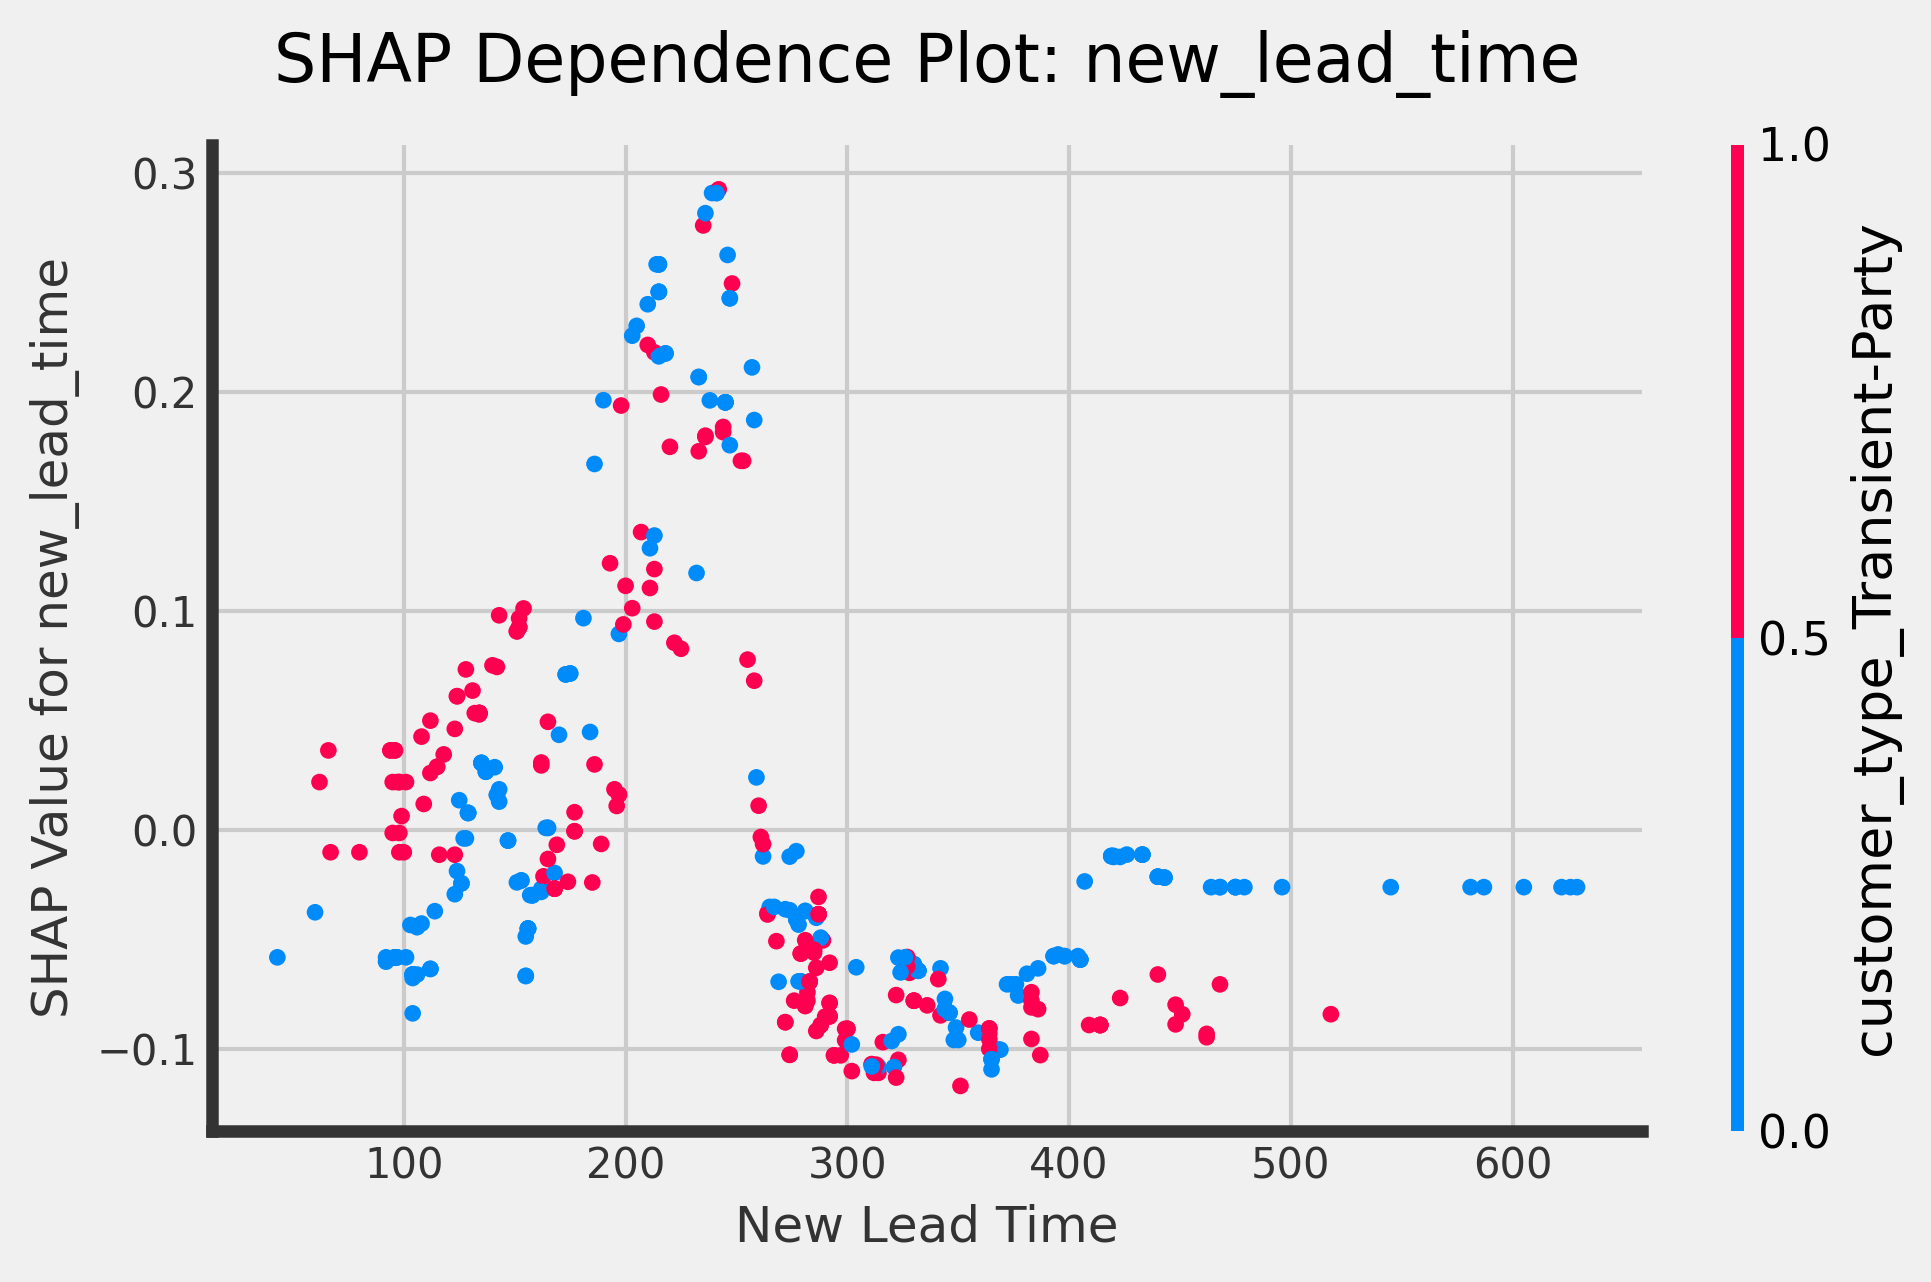

In [17]:
# SHAP dependence — new_lead_time
show_img(os.path.join(PLOTS_DIR, "slearner_shap_dependence_new_lead_time.png"), width=800)


### SHAP dependence: new_lead_time (colored by customer_type_Transient-Party)
- X-axis = lead time; Y-axis = SHAP for uplift (impact on treatment effect).
- Peak uplift at **~150-250 days**; **<100 days** small effect; **>300 days** low/negative.
- Color shows interaction: **blue (not Transient-Party)** drives most positive uplift; **red (Transient-Party)** is weaker/neutral.
- Targeting: focus on **non-Transient-Party** guests booking **150-250 days** ahead.


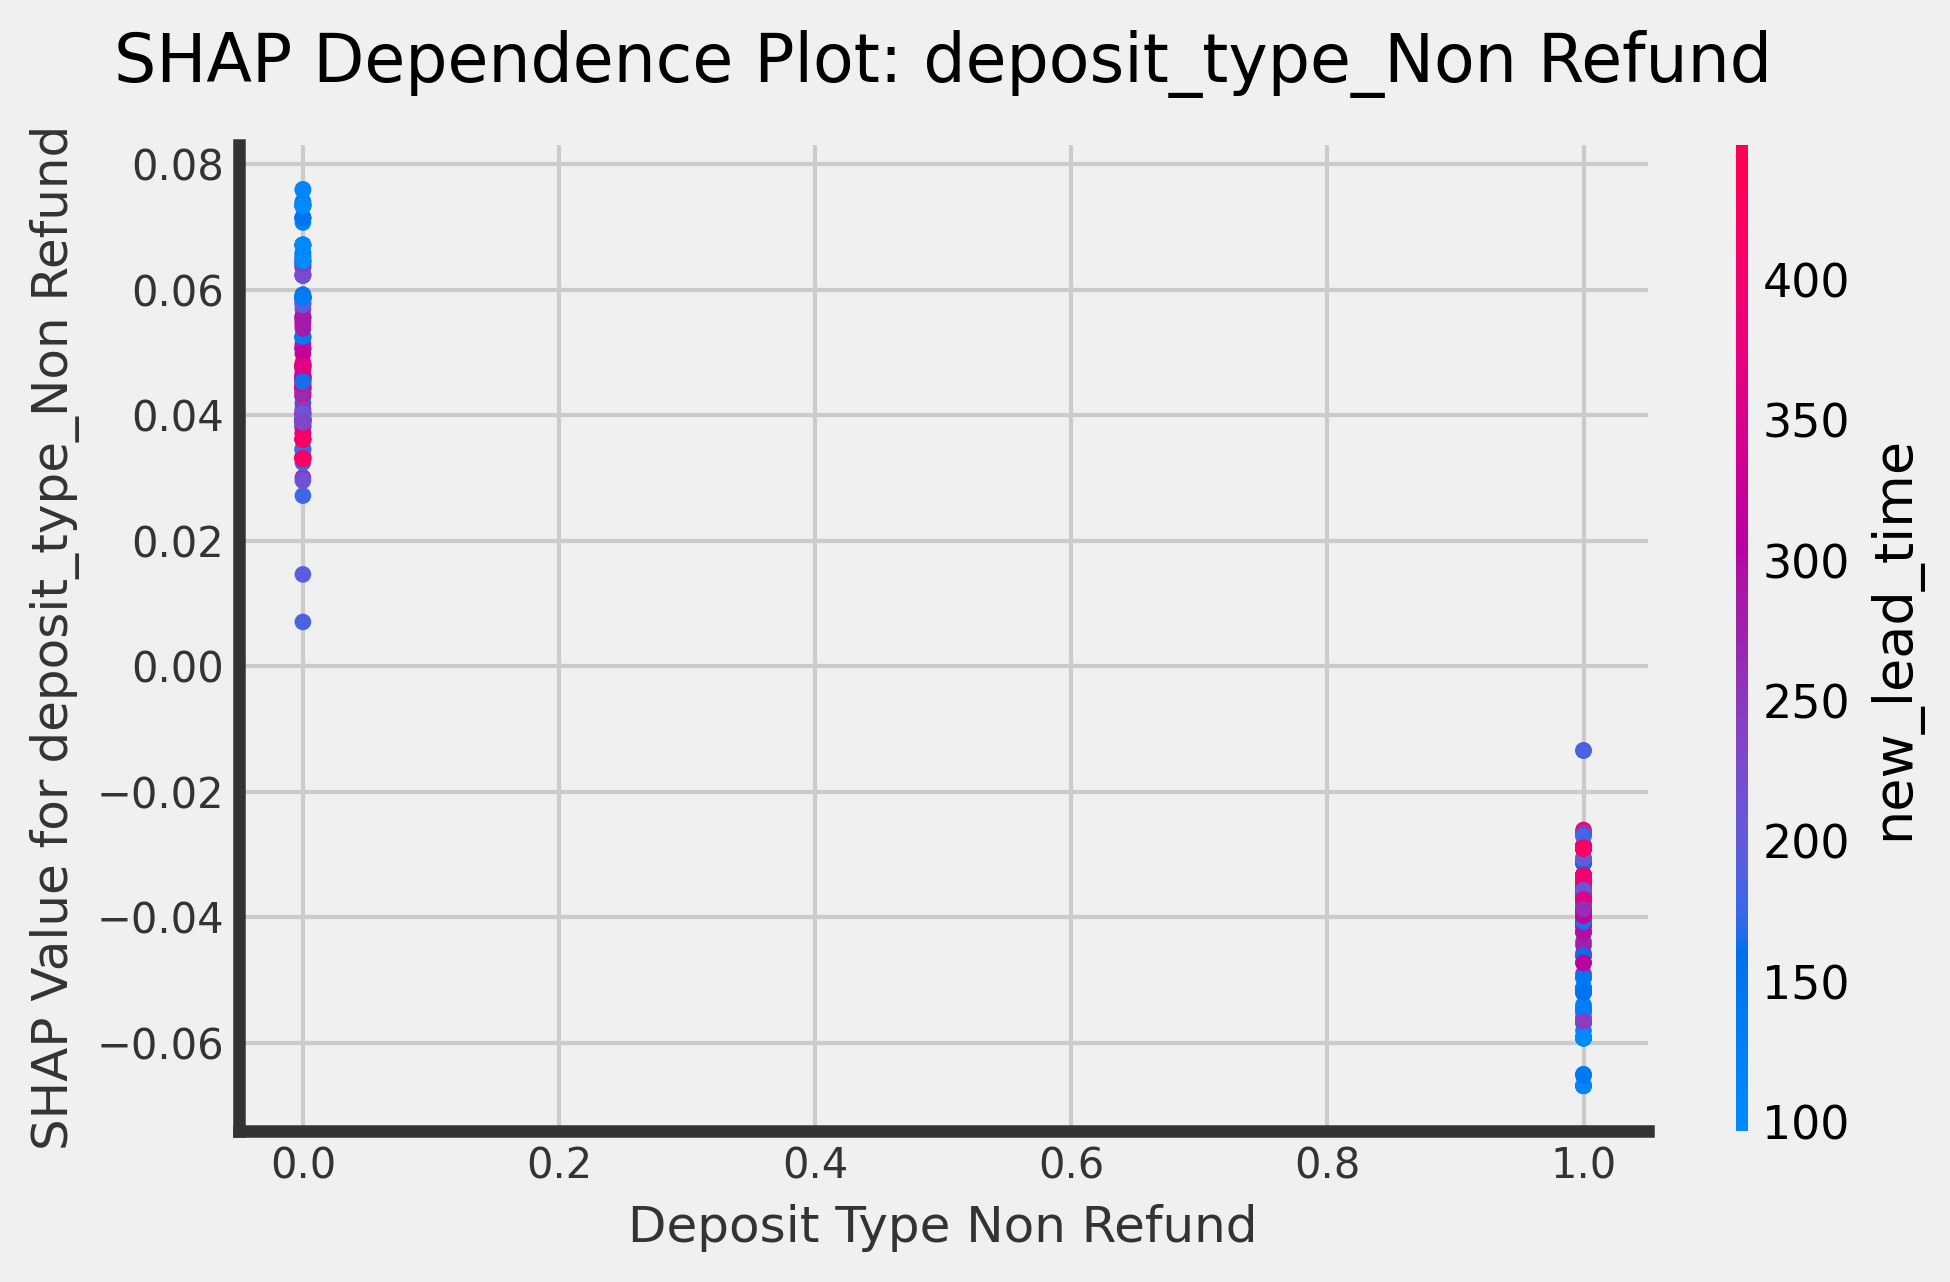

In [18]:
# SHAP dependence — deposit_type_Non Refund (colored by lead_time)
show_img(os.path.join(PLOTS_DIR, "slearner_shap_dependence_deposit_non_refund.png"), width=600)


### SHAP dependence: deposit_type_Non Refund (colored by new_lead_time)
- **x = 0 (Refundable/No-Deposit):** SHAP > 0 → increases uplift.
- **x = 1 (Non-Refund):** SHAP ≤ 0 → reduces uplift.
- Pattern holds across lead times (color varies, sign stays consistent).
- Targeting: favor **refundable/no-deposit** bookings; avoid **non-refund** bookings.


**Read Summary:**  
- **Lead time** is the strongest uplift driver; mid-range windows respond best.  
- **Refundable / No-Deposit** → **higher uplift**; **Non-Refund** → **lower/negative uplift**.  
- **City Hotel** tends to benefit more than Resort in this sample.

----------------------------------------------------------------------

# **D. Uplift Evaluation (Targeting Quality)**

- **Qini/AUUC** summarizes targeting value vs random.  
- Early steep rise ⇒ model ranks high-impact guests well.


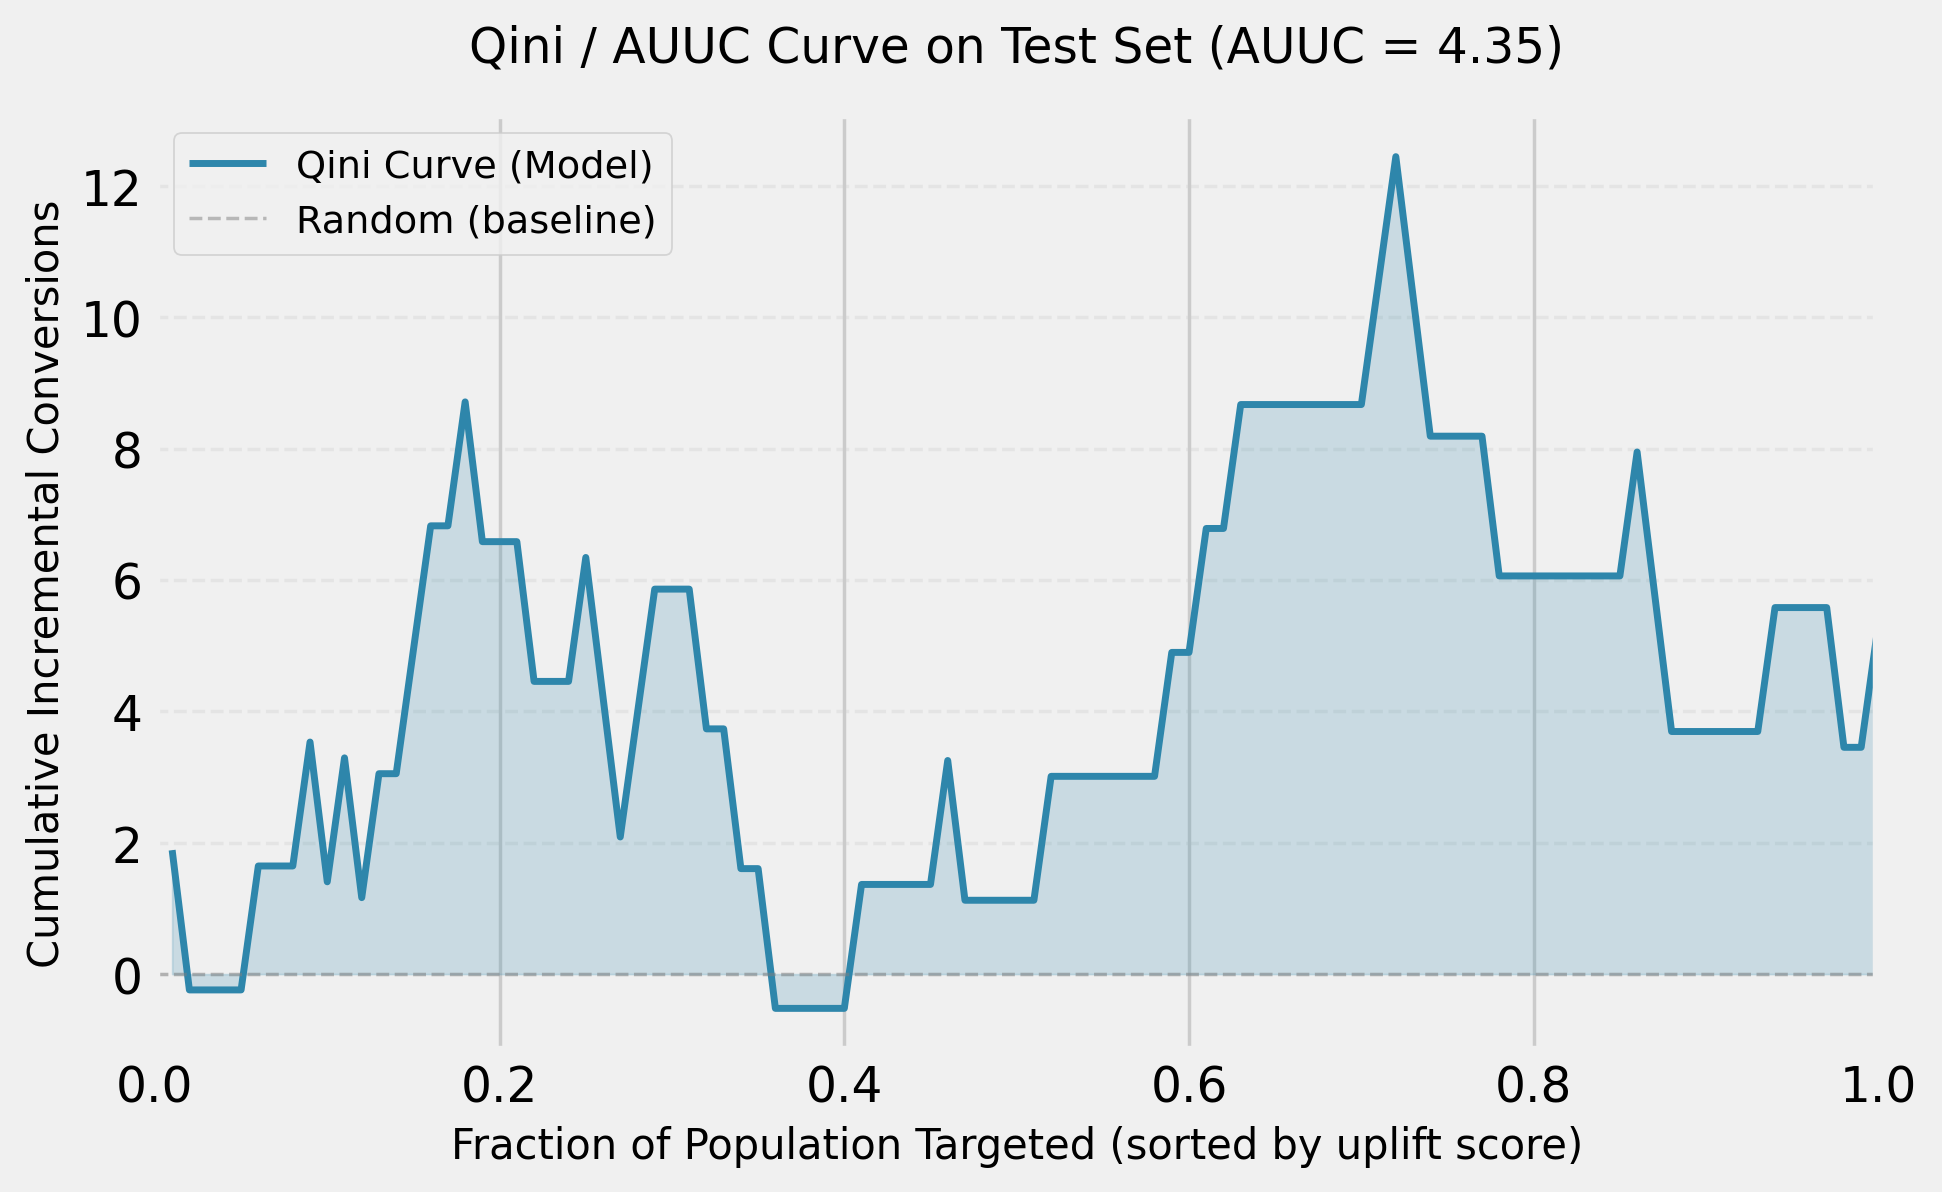

In [19]:
# Qini / AUUC curve
show_img(os.path.join(PLOTS_DIR, "qini_auuc_curve.png"), width=600)


### Qini / AUUC summary
- **Strong early lift:** Top **10-30%** of customers show the highest uplift (e.g., **+20 pp**, **+16.7 pp**), confirming the model ranks high-impact guests well. but after about 30%, uplift flattens and gets noisy then a smaller rise around **70%** (~**+12.6 pp**).

- **Overall value:** **AUUC = 4.35 > 0** showing model beats random targeting.

- **X-axis:** fraction of customers targeted (sorted by model uplift).  
- **Y-axis:** cumulative incremental conversions vs. control (total “extra keeps” up to that fraction).


-------------------------------------------------------------

# **E. ROI & \$ Impact**

**Assumptions (example in Notebook 02):**  
- Avg spend **\$1,500**, discount **10%** (cost **\$150** if convert)  
- Targeted **250**, accept **62**, cancels among acceptors **11**  
- Net revenue per targeted computed from:  
  **kept revenue – lost revenue from acceptor cancels – discount cost on kept**


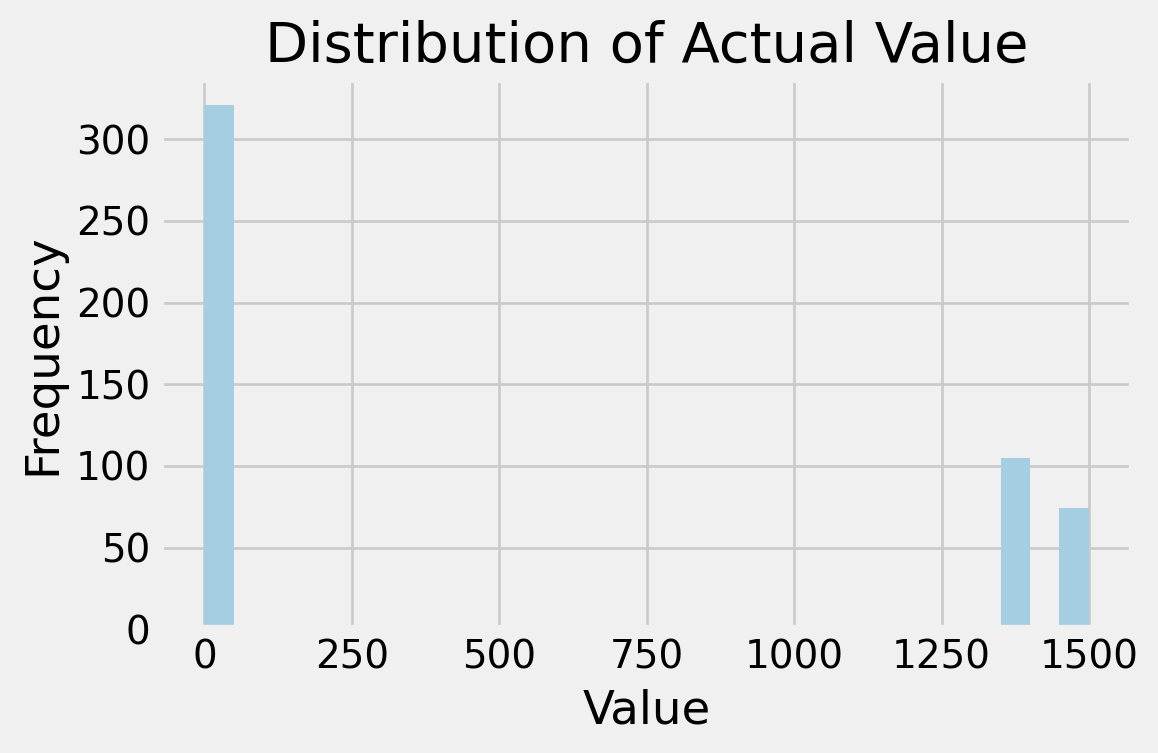

In [20]:
# value distribution (realized off-policy)
show_img(os.path.join(PLOTS_DIR, "value_distribution.png"), width=600)


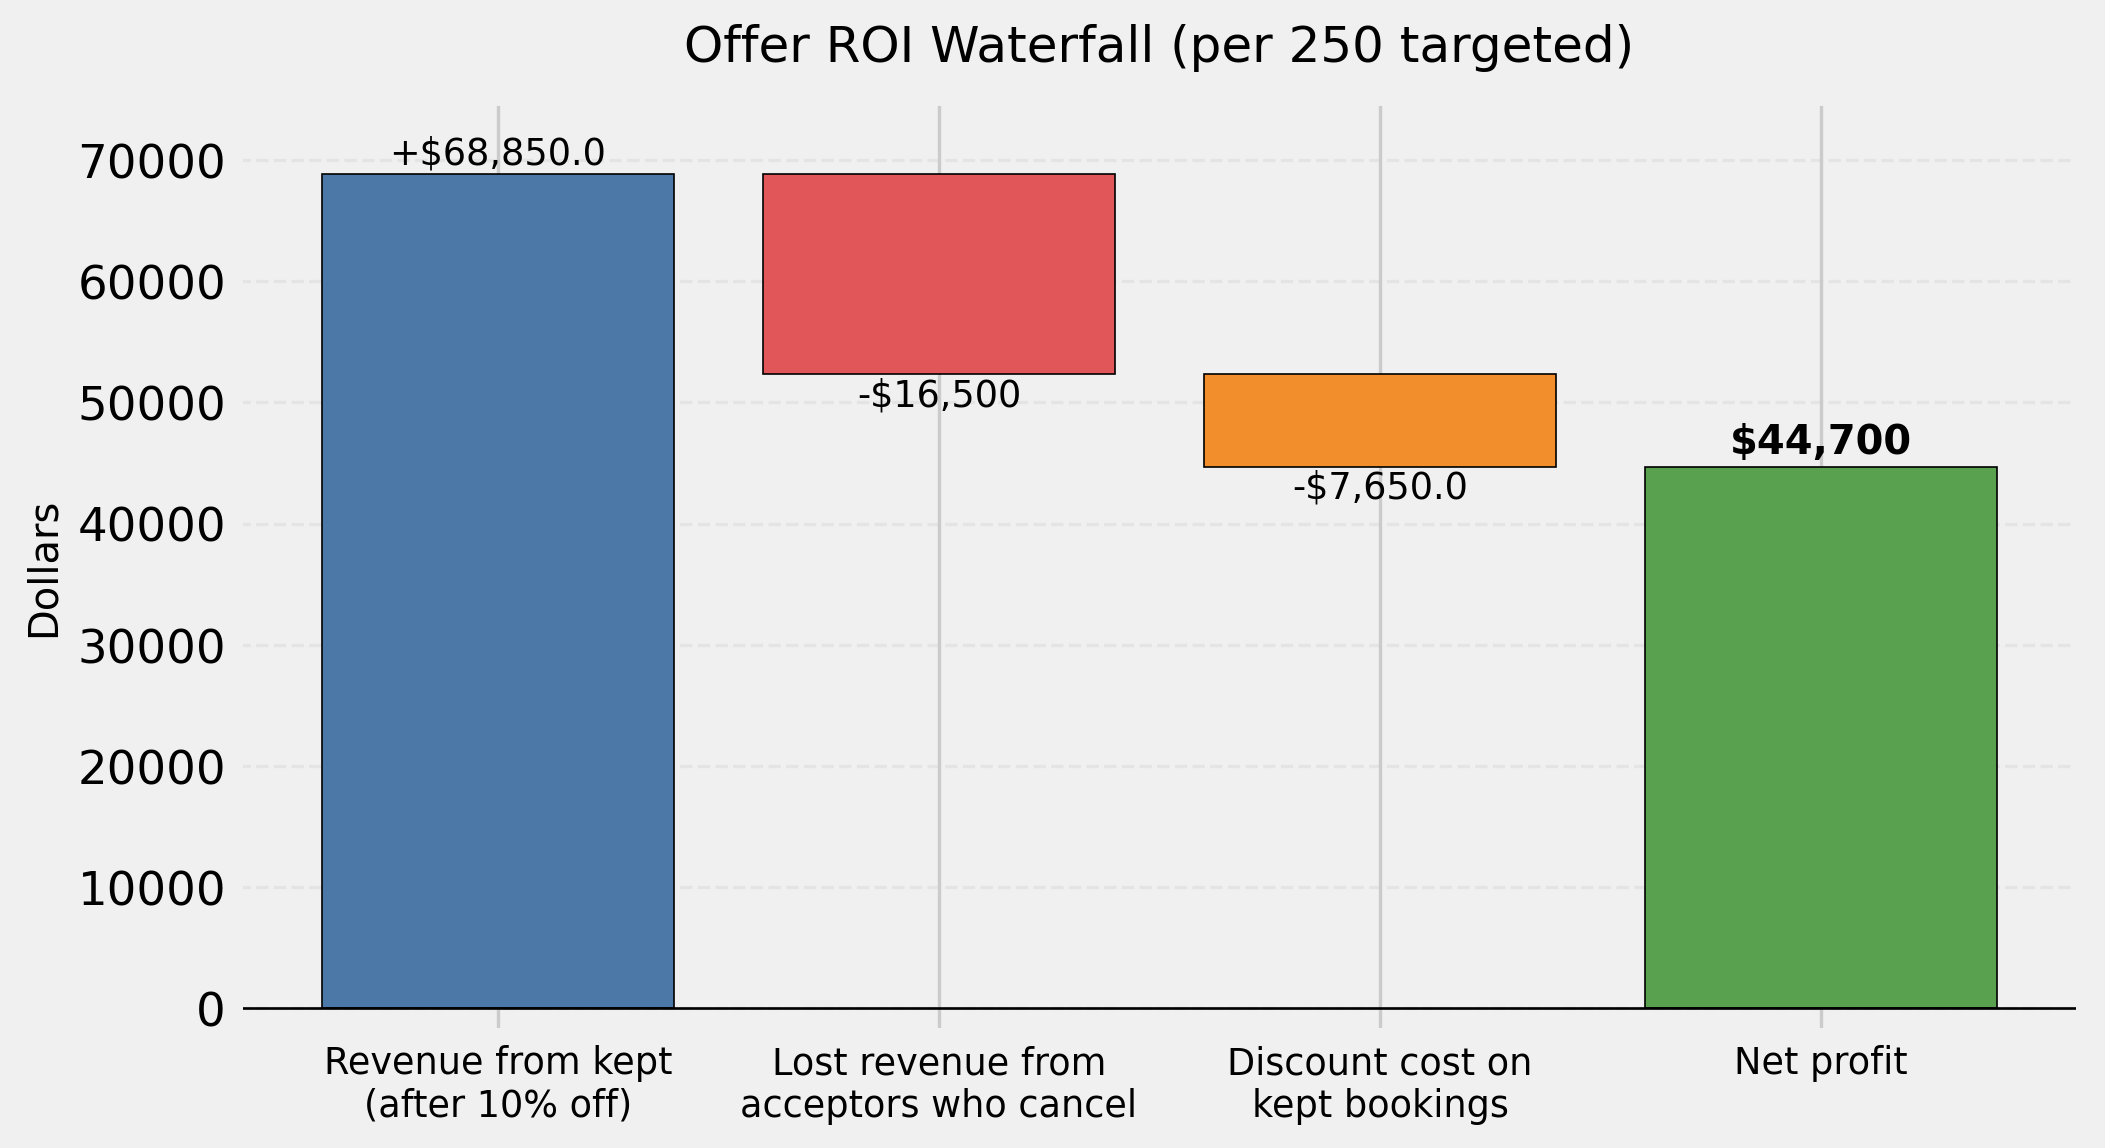

In [21]:
# Waterfall: where the dollars go (per 250 targeted)
show_img(os.path.join(PLOTS_DIR, "offer_roi_waterfall.png"), width=750)


- accept_rate_treat: 0.248 ---- # 24.8% of targeted guests accepted the offer.
- cancel_rate_accepted: 0.1774193548387097 ---- # Among acceptors, 17.7% still canceled.
- kept_bookings: 51 ---- # Net kept bookings from the offer: 51.
- expected_revenue: 68850 ---- # Revenue generated from kept bookings (after 10% discount).
- lost_revenue_from_cancels: 16500 ---- # Revenue lost from cancellations among acceptors/treatment converts.
- discount_cost_on_kept: 7650 ---- # Discount cost actually granted on kept bookings.
- net_revenue_per_customer_targeted: 178.8 ---- Net value per targeted customer: \$178.80.
- estimated_roi: \$3,542,207 ---- taken out of net dollars per targeted (after all adds/subtracts). Assuming 24.8% acceptance rate.
- Scaling to 19,811 similar customers yields ≈ $3,542,206.80 in projected value.


-------------------------------------------------------------

# **F. Policy Comparison (For deployment)**

- **Random allocation** (baseline)  
- **Best single arm (ATE)** on train, evaluated on test  
- **T-Learner (probability)**: choose arm with higher P(convert)  
- **T-Learner (value-aware)**: choose arm with higher **\$ expected value**  


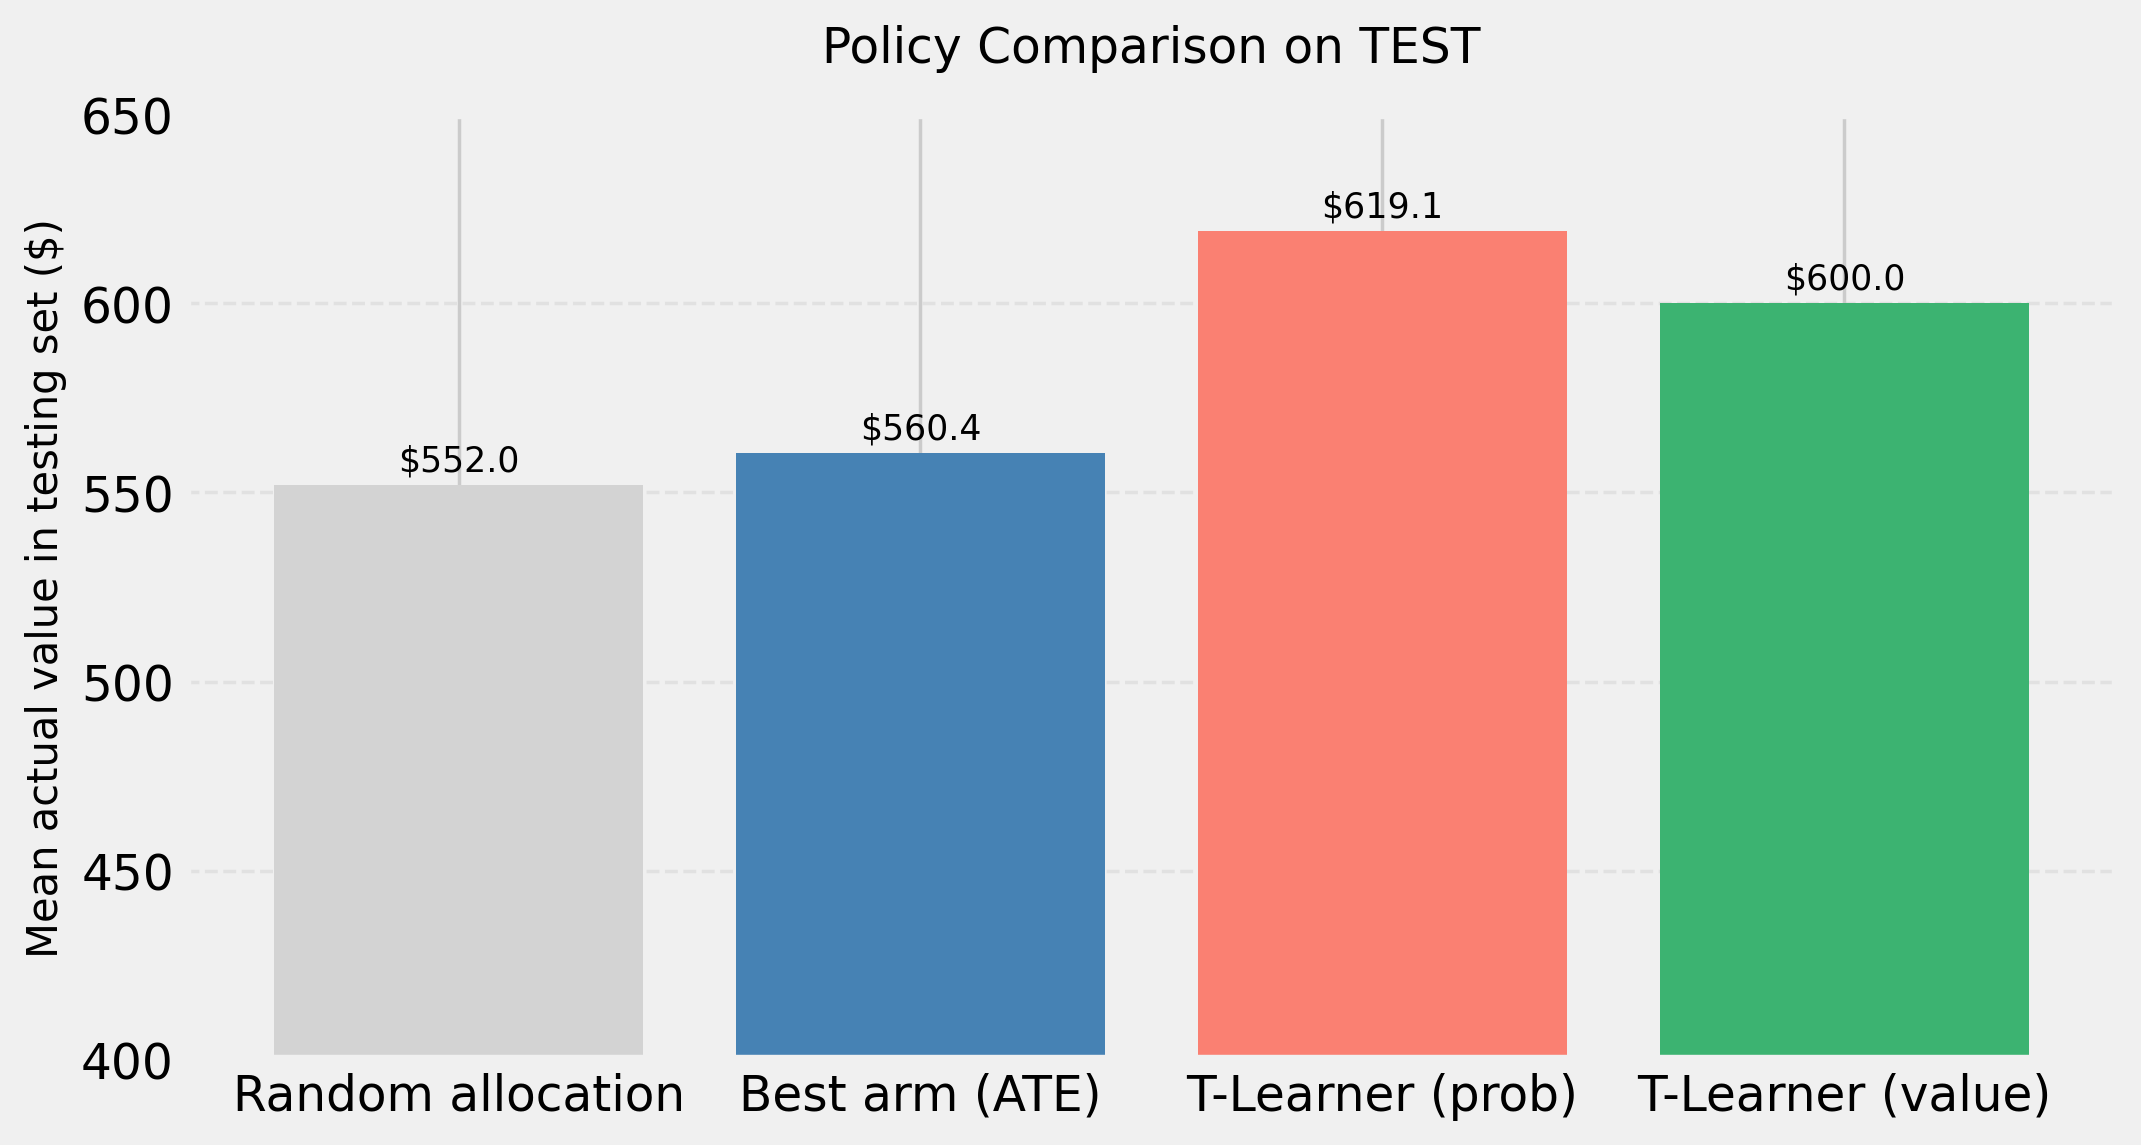

In [21]:
# Policy value comparison on TEST
show_img(os.path.join(PLOTS_DIR, "policy_value_comparison_valueaware_test.png"), width=750)


**Read:** Personalized **T-Learner** beats both random and best-arm.  
The T-Learner probability policy is selecting people more likely to convert Even though treatment has a $150 cost, the higher conversion rate compensates for it.

The personalized T-Learner earns \$60-70 more per guest than doing nothing, and about $40 more than simply treating everyone with the best arm.

-------------------------------------------------------------

# **G. Practical Targeting Rules (Rollout v1)**

- **Prioritize** guests with **refundable / no-deposit** and **lead time in mid-range** (per SHAP & tree).  
- **De-prioritize** **Non-Refund** segments; treat only if future evidence shows positive uplift.  
- **Cap** targeting around **top 20-30% uplift** for best ROI; expand cautiously beyond that.  
- **Monitor** ITT and Value-ITT each cycle; keep a holdout.  
- **Stratify** by season/hotel type if rolling over time (to control for drift).


# **H. Limitations & Next Steps**

- Sample is modest (**n=500**); variance in smaller leaves/segments.  
- Off-policy evaluation has **overlap limits**; consider **online A/B** for policy validation.  
- Add **cost heterogeneity** (discount elasticity, segment-specific ADR).  
- Re-train regularly; guard against **data leakage** in features (post-exposure variables).

**Deployment**
